<a href="https://colab.research.google.com/github/amehaabera/Money-Laundering-Using-Machine-Learning/blob/main/Money_Laundering_Using_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## `**Detecting Money Laundering: A Machine Learning Approach**`

The rise of financial crimes, particularly money laundering, demands advanced detection systems capable of identifying suspicious transactions within vast, imbalanced datasets. This thesis investigates the efficacy of machine learning algorithms in detecting money laundering, focusing on performance optimization through iterative experimentation, data preprocessing, and hyperparameter tuning. Five algorithms—Logistic Regression, K-Nearest Neighbors, Random Forest, XGBoost, and Support Vector Machines—were evaluated, with XGBoost emerging as the superior model due to its robustness in handling class imbalance and complex transactional patterns.
Exploratory data analysis revealed severe class imbalance, with only 913 suspicious transactions out of 572,196 total transactions (0.16%). The study highlights the critical role of SMOTE (Synthetic Minority Oversampling), which improved XGBoost’s recall to 99.96% (Iteration 3) while reducing false negatives to 51 cases. Iterative experiments identified transaction balances (Old/New Balance Orig/Dest) and transaction types (TRANSFER, CASH_OUT) as the most influential features, aligning with domain-specific laundering patterns. While Random Forest achieved 100% precision (Iteration 5), its high false-negative rate (e.g., 566 missed frauds in Iteration 3) limited its practical utility.
The findings underscore the limitations of accuracy in imbalanced contexts and advocate for the F1-score as a more reliable metric. The thesis concludes that XGBoost + SMOTE offers a scalable solution for financial institutions, demonstrated via a Streamlit-based deployment for real-time detection. This research contributes a practical framework for integrating machine learning into AML workflows, balancing detection efficacy with operational feasibility.



Dataset has fillowing columns:

Transaction ID  -  is a unique alphanumeric code that identifies a financial transaction.

Branch Name - a physical location of a bank that offers face-to-face services.Meanwhile where the account opend in this case.

Transaction Date - the date when a transaction occurs.

Transaction Time - The transaction time-period is the time when a transaction is valid.

Transaction Type - are categories that help classify and understand transactions. (Deposit,Withdrawal & Transfer)

Conducting Manner - channels used to access the accounts (Account to Account, Cash, Internet Banking and Mobile Banking)

Old Balance Org - initial balance before the transaction

New Balance Orig - new balance after the transaction

Amount In Birr - amount of the transaction in local currency.

Sex - The customer Gender Female or Male

Birthday - The customer age

Occupation - The customer job or profession.

City - The customer home city

Sub City - The customer home Sub city

Account No - A bank account number is a unique set of digits assigned to the account when you open a bank account.

Account Type

Old Balance Dest - initial balance recipient before the transaction.

Balance Held Dest - new balance recipient after the transaction.

is Fraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.
The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than ETB 300,000 (USD 15,000) in a single transaction.


Project Steps
1. Loading Data and EDA
2. Feature Engineering
3. Machine Learning
3.1.  Baseline Models
3.2.  Grid Search for Best Hyper-parameter
3.3.  Dealing with Unbalanced Data
3.3.1.  Balancing Data via Resambling with SMOTE
3.3.2.  Subsampling Data from the Original Dataset
3.3.3  Performing SMOTE on the New Data
4. Machine Learning Pipeline
5. Feature Importance
6. Conclusion
7. Future Works

1.Loading Data and EDA

In [ ]:
import os
import math
from numpy import *
import numpy as np
import pandas as pd
import random
import seaborn as sns #for visualization
import matplotlib.pyplot as plt #for visualization
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Load data
data = pd.read_csv ('/content/drive/MyDrive/Money_Laundering_Dataset.csv')
data

,Transaction ID,Branch Name,Transaction Date,Transaction Time,Transaction Type,Conducting Manner,Old Balance Org,New Balance Orig,Amount in Birr,Sex,Birth Date,Occupation,Sub City,Account No,Account Type,Old Balance Held Dest,Balance Held Dest,is Fraud
0,TT23122ZS7W9;1,DARUSELAM BRANCH,02-05-23,11:38,CASH_OUT,Cash,15325.00,0.00,229133.94,MALE,03-02-96,TREADER,AWI,28023405.0,WADIAH CURRENT,5083.00,51513.44,0
1,TT23122NGHZK;1,BALDERAS CONDOMIN BR,02-05-23,16:24,TRANSFER,Cash,705.00,0.00,215310.30,MALE,04-02-90,UNEMPLOYED,ARADA,40108475.0,SAV INT BEARING,22425.00,0.00,0
2,TT23122HR4K1;1,DIRE DAWA BRANCH,02-05-23,9:18,TRANSFER,Cash,10835.00,0.00,311685.89,MALE,02-01-62,SELF EMPLOYED,DD,40958681.0,SPECIAL SAVINGS,6267.00,2719172.89,0
3,TT23122667PT;1,MINA BRANCH,02-05-23,16:57,CASH_OUT,Cash,26845.41,0.00,110414.71,MALE,03-02-78,SELF EMPLOYED,S/WOLLO,42354236.0,WADIAH SAVING,288800.00,2415.16,0
4,TT23122SR53Z;1,WOYIN WUHA BRANCH,02-05-23,8:17,CASH_OUT,Cash,1942.02,0.00,56953.90,MALE,03-02-85,Not Available,W/GOJJAM,46048954.0,SAV INT BEARING,70253.00,64106.18,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
572191,FT231715BKJY;1,NEGUS SAHLESLASSIE BRA,30-09-23,11:43,CASH_OUT,Account to Account,107623.00,4231.07,103391.93,MALE,14-Feb-89,PRIVATE,DB,59843807.0,WADIAH SAVING,5752648.68,5856040.61,0
572192,FT231713CGHJ;1,NEGUS SAHLESLASSIE BRA,30-09-23,15:20,CASH_IN,Account to Account,41533.00,154945.53,113412.53,MALE,19-Mar-82,PRIVATE,NORTH SHOWA,36760575.0,WADIAH SAVING,565908.33,452495.80,0
572193,FT23171VLZP1;1,ADISHIM DHUN BRANCH,30-09-23,14:42,TRANSFER,Account to Account,15956.51,0.00,132387.24,MALE,03-Feb-84,NONE,DEBUB,54034806.0,SAV INT BEARING,631284.08,763671.32,0
572194,FT23171F144Q;1,SHEWA BER BRANCH,30-09-23,17:34,CASH_OUT,Account to Account,18002.85,0.00,279674.05,MALE,17-Mar-91,PERSONAL,JINELA,25603109.0,WADIAH SAVING,1847488.28,2127162.32,0


In [ ]:
## Summary of the dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572196 entries, 0 to 572195
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Transaction ID         572196 non-null  object 
 1   Branch Name            572196 non-null  object 
 2   Transaction Date       572196 non-null  object 
 3   Transaction Time       572196 non-null  object 
 4   Transaction Type       572196 non-null  object 
 5   Conducting Manner      529509 non-null  object 
 6   Old Balance Org        572196 non-null  float64
 7   New Balance Orig       572196 non-null  float64
 8   Amount in Birr         572196 non-null  float64
 9   Sex                    566839 non-null  object 
 10  Birth Date             564985 non-null  object 
 11  Occupation             567945 non-null  object 
 12  Sub City               568497 non-null  object 
 13  Account No             572193 non-null  float64
 14  Account Type           572098 non-nu

In [ ]:
## Finding null values
data.isna().sum()

,0
Transaction ID,0
Branch Name,0
Transaction Date,0
Transaction Time,0
Transaction Type,0
Conducting Manner,42687
Old Balance Org,0
New Balance Orig,0
Amount in Birr,0
Sex,5357


Null Values are present and need to perform SimpleImputer Median for Numerical & Most_Frequent to categorical variable.

In [ ]:
## Finding duplicates in Rows
data.duplicated().sum()

np.int64(0)

In [ ]:
## Most_Frequent for convertinig null values for Categorical Variable

from sklearn.impute import SimpleImputer

# Separate the columns with missing values
missing_col1 = ['Conducting Manner', 'Sex', 'Birth Date','Occupation', 'Sub City' , 'Account Type']

# Create a KNN imputer object
imputer = SimpleImputer(strategy='most_frequent')

# Impute the missing values
data[missing_col1] = imputer.fit_transform(data[missing_col1])


In [ ]:
## Using Median Simple Imputer to convert Null Values Present in Numericals

from sklearn.impute import SimpleImputer

# Separate the columns with missing values
missing_cols = ['Account No']

imputer = SimpleImputer(strategy='median')

# Impute the missing values
data[missing_cols] = imputer.fit_transform(data[missing_cols])

In [ ]:
data.isna().sum()

,0
Transaction ID,0
Branch Name,0
Transaction Date,0
Transaction Time,0
Transaction Type,0
Conducting Manner,0
Old Balance Org,0
New Balance Orig,0
Amount in Birr,0
Sex,0


In [ ]:
#examine the dataset
data.describe()

,Old Balance Org,New Balance Orig,Amount in Birr,Account No,Old Balance Held Dest,Balance Held Dest,is Fraud
count,5.721960e+05,5.721960e+05,5.721960e+05,5.721960e+05,5.721960e+05,5.721960e+05,572196.000000
mean,1.197986e+06,1.236970e+06,2.782937e+05,7.293919e+07,1.535555e+06,1.769501e+06,0.001596
std,3.453921e+06,3.504539e+06,3.114226e+05,1.116556e+08,2.739052e+06,2.858872e+06,0.039913
min,0.000000e+00,0.000000e+00,5.509117e+04,3.290000e+02,0.000000e+00,0.000000e+00,0.000000
25%,0.000000e+00,0.000000e+00,1.208090e+05,3.066429e+07,1.534622e+05,2.688294e+05,0.000000
50%,1.779800e+04,0.000000e+00,1.982596e+05,6.727429e+07,5.868437e+05,7.947679e+05,0.000000
75%,2.007973e+05,2.958836e+05,3.184571e+05,1.086463e+08,1.694951e+06,2.034224e+06,0.000000
max,3.860000e+07,3.890000e+07,1.000000e+07,9.696970e+09,4.210000e+07,4.220000e+07,1.000000


<ipython-input-11-d82ba10480ff>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['Transaction Hour'])


Text(0.5, 1.0, 'Distribution of Transactions over the Time')

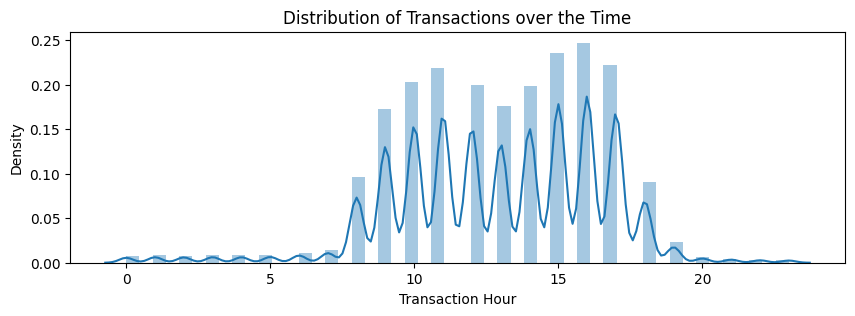

In [ ]:
#Distribution of the frequency of all transactions

# Convert 'Transaction Time' to a 24-hour format
# Extract just the hour component from 'Transaction Time' without considering the minutes
data['Transaction Hour'] = pd.to_datetime(data['Transaction Time'], format='%H:%M').dt.hour

plt.figure(figsize=(10, 3))
sns.distplot(data['Transaction Hour'])
plt.title('Distribution of Transactions over the Time')


There are no duplicate rows, so we do not need to worry about duplicated data.

Examine the data by the labels
I will filter the data by the labels and examine two groups compairing each other.

In [ ]:
# Filter data by the labels. Safe and Fraud transaction
safe = data[data['is Fraud']==0]
fraud = data[data['is Fraud']==1]

<ipython-input-13-1248985cd6d1>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(safe['Transaction Hour'], label="Safe Transaction")
<ipython-input-13-1248985cd6d1>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(fraud['Transaction Hour'], label="Fraud Transaction")


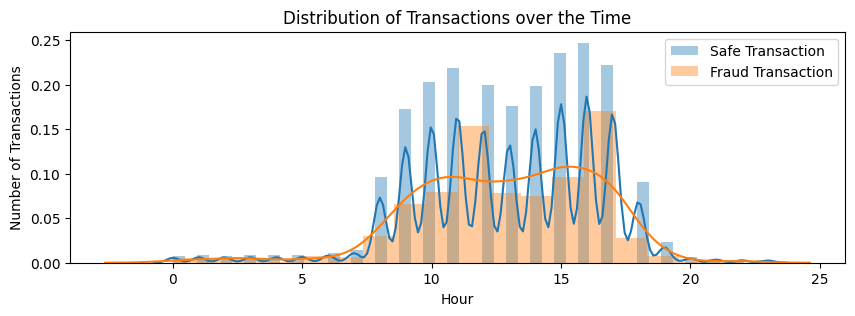

In [ ]:
#See the frequency of the transactions for each class on the same plot.
plt.figure(figsize=(10, 3))
sns.distplot(safe['Transaction Hour'], label="Safe Transaction")
sns.distplot(fraud['Transaction Hour'], label="Fraud Transaction")
plt.xlabel('Hour')
plt.ylabel('Number of Transactions')
plt.title('Distribution of Transactions over the Time')
plt.legend()

This fluctuation suggests that suspicious activities may coincide with times when legitimate transactions peak, indicating that malicious actors might time their actions strategically.

Hourly Transaction Amounts

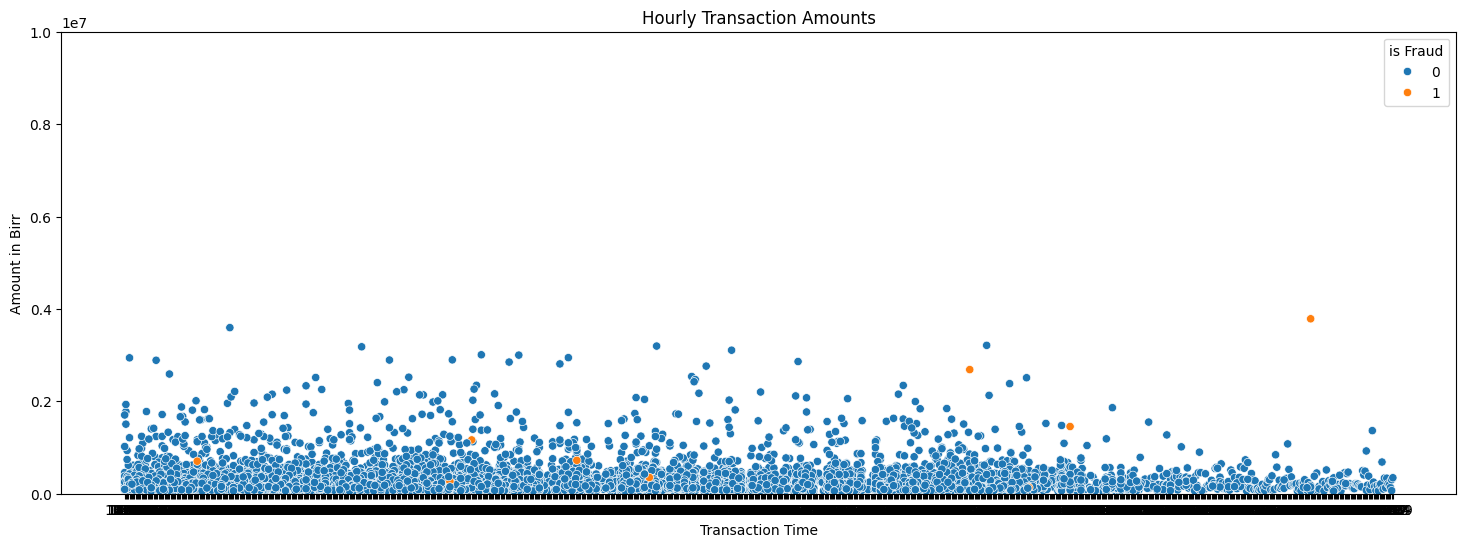

In [ ]:
#just use small portion of data to scatterplot the transaction happens every hour and their amount.
smalldata=data.sample(n=10000, random_state=1)
smalldata=smalldata.sort_index()
smalldata=smalldata.reset_index(drop=True)

#plot the small data
plt.figure(figsize=(18,6))
plt.ylim(0, 10000000)
plt.title('Hourly Transaction Amounts')
ax = sns.scatterplot(x="Transaction Time", y="Amount in Birr", hue="is Fraud",
                     data=smalldata)

The overall pattern shows that while the majority of transactions are relatively uniform and low, the fraudulent ones stand out as isolated instances above the typical range.

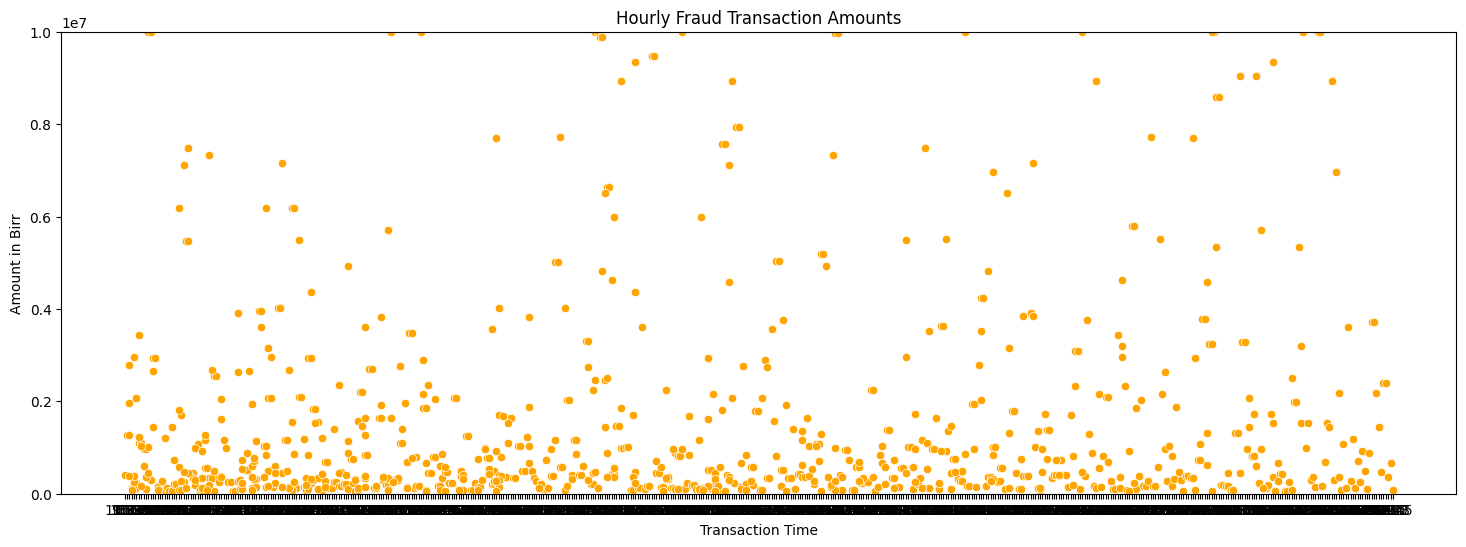

In [ ]:
#The hourly amount of al fraud transactions
plt.figure(figsize=(18,6))
plt.ylim(0, 10000000)
plt.title('Hourly Fraud Transaction Amounts')
ax = sns.scatterplot(x="Transaction Time", y="Amount in Birr", color='orange',
                     data=fraud)

The plot displays hourly fraudulent transaction amounts in Birr, with all data points represented as orange dots. Most transactions cluster near zero, indicating low amounts, while a few scattered points reach higher values, highlighting significant fraudulent activities. This visual suggests that fraudulent transactions are relatively rare compared to the overall volume of transactions.

Transaction Amount Distributions

<ipython-input-16-07090266c11e>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(safe['Amount in Birr'])


<Axes: title={'center': 'Safe Transaction Amount Distribution'}, xlabel='Amount in Birr', ylabel='Density'>

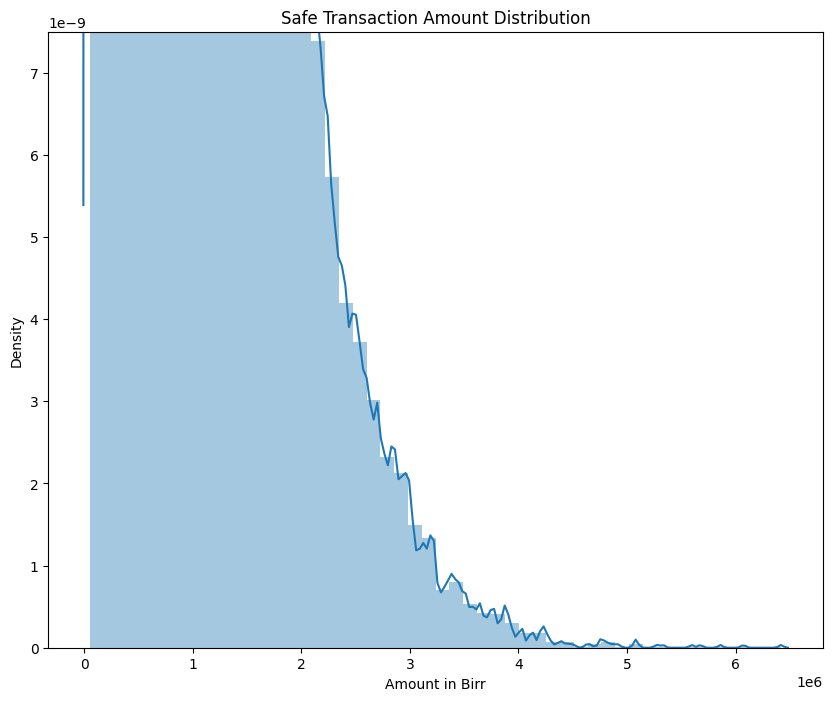

In [ ]:
#safe transactions amount distribution plot
plt.figure(figsize=(10,8))
plt.ylim(0, 0.0000000075)
plt.title('Safe Transaction Amount Distribution')
sns.distplot(safe['Amount in Birr'])


The plot depicts the distribution of safe transaction amounts in Birr, displaying a steep decline in density as the transaction values increase. Most transactions are concentrated at lower amounts, with the density tapering off significantly beyond 2 million Birr, suggesting that higher-value transactions are quite rare. This pattern indicates a preference for lower transaction amounts within the safe transaction dataset.

In [ ]:
safe['Amount in Birr'].describe()

,Amount in Birr
count,5.712830e+05
mean,2.763633e+05
std,2.953898e+05
min,5.509117e+04
25%,1.207597e+05
50%,1.981101e+05
75%,3.180355e+05
max,6.419835e+06


The summary statistics reveal that the safe transaction amounts have a mean of approximately 276,363 Birr, with a notable standard deviation of 295,389 Birr, indicating significant variation within the dataset, while the amounts range from a minimum of about 55,091 Birr to a maximum of 6,419,835 Birr.

<ipython-input-18-f0329041e167>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(fraud['Amount in Birr'])


<Axes: title={'center': 'Fraud Transaction Amount Distribution'}, xlabel='Amount in Birr', ylabel='Density'>

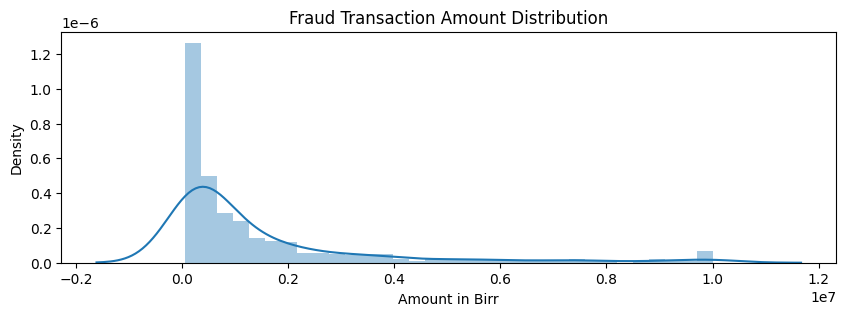

In [ ]:
# Fraud transactions amount distribution plot
plt.figure(figsize=(10,3))
plt.title('Fraud Transaction Amount Distribution')
sns.distplot(fraud['Amount in Birr'])

The plot illustrates the distribution of fraudulent transaction amounts in Birr, showing a significant peak at lower transaction values, which indicates that most fraudulent activities are concentrated around these amounts. The density gradually decreases, with very few transactions reaching higher values, suggesting that high-value fraudulent transactions are particularly rare. Overall, the distribution highlights a skew towards smaller fraud amounts, with a long tail extending towards larger values.

In [ ]:
# fraud transactions amount value counts
fraud['Amount in Birr'].value_counts()

,count
Amount in Birr,
10000000.00,14
150405.20,2
126690.14,2
403975.39,2
174923.28,2
...,...
149668.66,1
222048.71,1
454859.39,1


The value counts for fraudulent transaction amounts indicate that the most common amount is 10,000,000 Birr, appearing 14 times, while a variety of other amounts appear less frequently, with many transactions occurring just once. This suggests that while there are numerous unique fraud amounts, a small number of them dominate the dataset, particularly the large transaction of 10,000,000 Birr. The presence of multiple unique amounts could indicate diverse fraudulent activities within different value ranges.

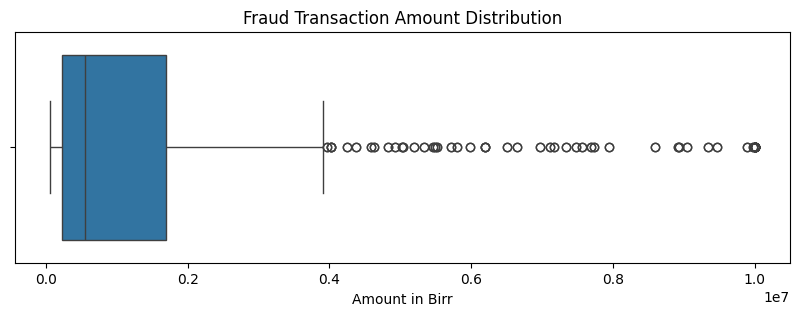

In [ ]:
#Fraud transaction boxplot for amount distribution
plt.figure(figsize=(10,3))
plt.title('Fraud Transaction Amount Distribution')
ax = sns.boxplot(x=fraud["Amount in Birr"])

The box plot illustrates the distribution of fraudulent transaction amounts, revealing a significant concentration of values within the interquartile range (IQR) from approximately 0 to 400,000 Birr. Several outliers extend beyond the upper whisker, indicating a few exceedingly high fraudulent transactions, with the maximum amount approaching 10 million Birr. This highlights the occurrence of rare, large-scale frauds amidst a larger number of smaller fraudulent activities.

In [ ]:
fraud['Amount in Birr'].describe()

,Amount in Birr
count,9.130000e+02
mean,1.486201e+06
std,2.174481e+06
min,5.674514e+04
25%,2.220487e+05
50%,5.562180e+05
75%,1.698264e+06
max,1.000000e+07


The summary statistics for fraudulent transaction amounts indicate a mean of approximately 1,486,201 Birr, with a high standard deviation of 2,174,481 Birr, reflecting considerable variability in transaction sizes. The values range from a minimum of about 56,745 Birr to a maximum of 10,000,000 Birr, suggesting there are both small and exceptionally large fraudulent transactions within the dataset. The quartile values further demonstrate that the majority of fraud occurs in the lower ranges, while high-value transactions, although fewer, significantly impact the average.

In [ ]:
#average amount for frauds below 400K
fraud[fraud['Amount in Birr']<400000]['Amount in Birr'].mean()

np.float64(199473.28747368424)

The average amount for fraudulent transactions below 400,000 Birr is approximately 199,473 Birr. This indicates that while there are some high-value fraud cases, the typical amount for lower-value fraudulent transactions is significantly less, highlighting a different scale of fraudulent activity within this range.

Type of Transactions

In [ ]:
#checking Conducting Manner of  safe transactions
safe['Conducting Manner'].value_counts()

,count
Conducting Manner,
Account to Account,302197
Cash,220769
Internet Banking,36450
Mobile Banking,11867


In [ ]:
#checking Conducting Manner of fraud transactions
fraud['Conducting Manner'].value_counts()


,count
Conducting Manner,
Account to Account,666
Cash,150
Internet Banking,87
Mobile Banking,10


In [ ]:
#checking Conducting Manner of fraud transactions
fraud['Transaction Type'].value_counts()

,count
Transaction Type,
CASH_OUT,462
TRANSFER,451


Rate of Fraud Transactions

In [ ]:
#proportion of number of frauds
data ['is Fraud'].value_counts()[1]/(data ['is Fraud'].value_counts()[0]+data ['is Fraud'].value_counts()[1])


np.float64(0.0015956070996651498)

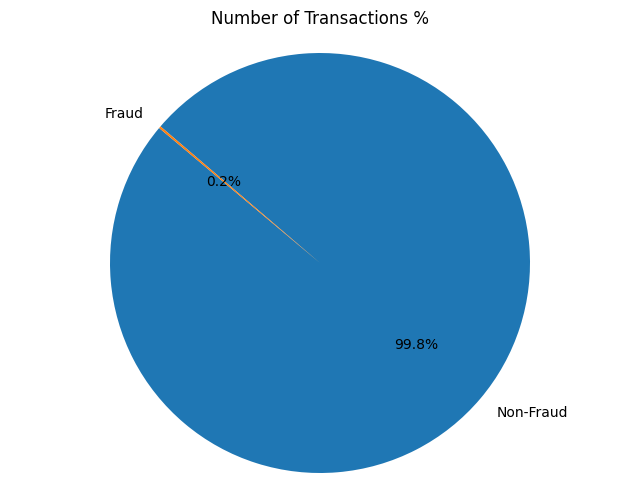

In [ ]:
# Assuming `data` is your DataFrame and 'isFraud' is the target column
fraud_counts = data['is Fraud'].value_counts()
labels = ['Non-Fraud', 'Fraud']
sizes = [fraud_counts[0], fraud_counts[1]]
# Plot the pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['#1f77b4','#ff7f0e'])
plt.title('Number of Transactions %')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

The pie chart highlights the stark contrast between fraudulent and non-fraudulent transactions, with fraud comprising just 0.2% of the total transactions. This indicates that the vast majority, 99.8%, of transactions are legitimate, underscoring the rarity of fraud within the dataset. The visualization effectively emphasizes the overwhelming prevalence of non-fraudulent activities relative to fraudulent ones.

In [ ]:
#proportion of fraud amount
fraud['Amount in Birr'].sum()/(safe['Amount in Birr'].sum()+fraud['Amount in Birr'].sum())

np.float64(0.008521189076551824)

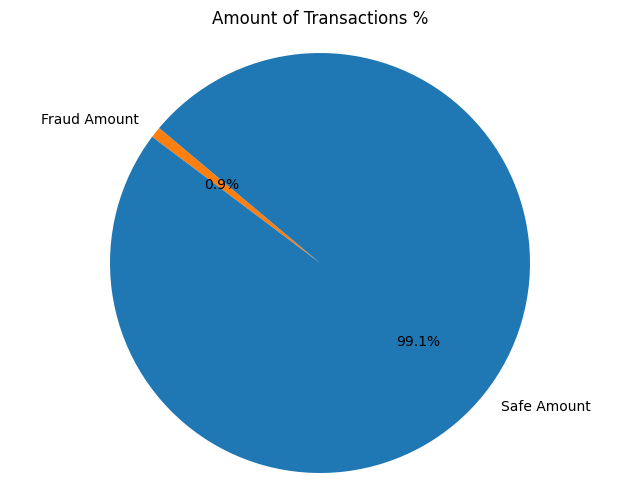

In [ ]:
# Assuming `fraud` and `safe` are DataFrames with the appropriate amounts
fraud_amount = fraud['Amount in Birr'].sum()
safe_amount = safe['Amount in Birr'].sum()

# Calculate proportions
total_amount = fraud_amount + safe_amount
proportions = [fraud_amount, safe_amount]
labels = ['Fraud Amount', 'Safe Amount']
import matplotlib.pyplot as plt

# Plot the pie chart
plt.figure(figsize=(8, 6))
plt.pie(proportions, labels=labels, autopct='%1.1f%%', startangle=140, colors=['#ff7f0e', '#1f77b4'])
plt.title('Amount of Transactions %')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

The pie chart visually conveys that fraudulent transactions account for only 0.9% of the total amount, while safe transactions dominate at 99.1%. This stark disparity highlights the rarity of fraud compared to legitimate transactions, emphasizing the overall integrity of the dataset. The clear distinction between the two categories reinforces the effectiveness of fraud detection measures in identifying outliers.

is Fraud column

Lets examine the is Fraud column.

In [ ]:
#value counts of is Fraud column
data['is Fraud'].value_counts()

,count
is Fraud,
0,571283
1,913


In [ ]:
#there are only 913 positive value. lets see which ones they are.
data[data['is Fraud']==1]

,Transaction ID,Branch Name,Transaction Date,Transaction Time,Transaction Type,Conducting Manner,Old Balance Org,New Balance Orig,Amount in Birr,Sex,Birth Date,Occupation,Sub City,Account No,Account Type,Old Balance Held Dest,Balance Held Dest,is Fraud,Transaction Hour
312,TT23122YLFR9;1,JIJIGA BRANCH,02-05-23,11:33,CASH_OUT,Cash,0.00,0.0,416001.33,MALE,05-04-90,SELF EMPLOYED,FAFEN,109320153.0,SAV INT BEARING,102.00,9291619.62,1,11
396,TT23122H0B74;1,SARIS BRANCH,02-05-23,9:39,TRANSFER,Cash,1277212.77,0.0,1277212.77,MALE,02-01-98,PRIVATE,GULELE,111866503.0,AFLA SAVING,0.00,0.00,1,9
397,TT2312240RSG;1,TULU BOLO BRANCH,02-05-23,16:09,CASH_OUT,Cash,1277212.77,0.0,1277212.77,MALE,03-02-75,PRIVATE,SOUTH WEST SHOA,110752709.0,SAV INT BEARING,0.00,2444985.19,1,16
677,TT23122MQ2ZX;1,GENDE KORE BRANCH,02-05-23,10:37,CASH_OUT,Cash,4499.08,0.0,132842.64,MALE,01-01-76,SELF,BALE ROBE,133894225.0,WADIAH SAVING,0.00,132842.64,1,10
807,TT23122BPFN4;1,CHEFE DONSA BRANCH,02-05-23,15:29,TRANSFER,Cash,235238.66,0.0,235238.66,MALE,04-02-64,Private,BALE ROBE,102211917.0,BALEWUL SAVING,0.00,0.00,1,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571341,FT23171YRPQ8;1,TELE MEDHANEALEM BR,30-09-23,14:27,CASH_OUT,Account to Account,655676.97,0.0,655676.97,MALE,26-Jul-70,BUSINESS MAN,BOLE,11694427.0,SAV INT BEARING,53614.28,709291.25,1,14
572028,FT231717M6MK;1,ADAGO BRANCH,30-09-23,17:05,TRANSFER,Account to Account,56745.14,0.0,56745.14,MALE,06-Mar-54,Private,NORTH WOLLO,100944391.0,SAV INT BEARING,0.00,0.00,1,17
572029,FT231712CML7;1,DJZ TESHOME SHNKUT BR,30-09-23,16:40,CASH_OUT,Account to Account,56745.14,0.0,56745.14,MALE,02-Jan-87,GOVERNMENT,N/SHOA,25420896.0,SAV INT BEARING,51433.88,108179.02,1,16
572147,FT23171P19QQ;1,WELETE BRANCH,30-09-23,15:33,TRANSFER,Account to Account,87999.25,0.0,87999.25,MALE,18-Mar-90,Private,SPECIAL,79786322.0,Fitayah Savings,0.00,0.00,1,15


2. Feature Engineering

Binary encoding the type column

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Separate columns by encoding type
account_type_col = ['Account Type']  # LabelEncode this
nominal_cols = ['Transaction Type', 'Conducting Manner', 'Sex']  # One-Hot these

# LabelEncode ONLY 'Account Type' (ordinal treatment)

account_encoder = LabelEncoder()
data['Account Type'] = account_encoder.fit_transform(data['Account Type'])

# One-Hot Encode the nominal features (Transaction Type, Sex, etc.)

data = pd.get_dummies(
    data,
    columns=nominal_cols,
    drop_first=True,  # Reduces multicollinearity
    dtype=int  # Ensures 0/1 integers instead of booleans
)



Lets drop the Account No colums since it is senseative information.

In [ ]:
#drop the name columns
data = data.drop(['Account No' , 'Transaction ID' , 'Branch Name' , 'Occupation', 'Sub City'], axis=1)
data

,Transaction Date,Transaction Time,Old Balance Org,New Balance Orig,Amount in Birr,Birth Date,Account Type,Old Balance Held Dest,Balance Held Dest,is Fraud,Transaction Hour,Transaction Type_CASH_OUT,Transaction Type_DEBIT,Transaction Type_PAYMENT,Transaction Type_TRANSFER,Conducting Manner_Cash,Conducting Manner_Internet Banking,Conducting Manner_Mobile Banking,Sex_MALE
0,02-05-23,11:38,15325.00,0.00,229133.94,03-02-96,67,5083.00,51513.44,0,11,1,0,0,0,1,0,0,1
1,02-05-23,16:24,705.00,0.00,215310.30,04-02-90,46,22425.00,0.00,0,16,0,0,0,1,1,0,0,1
2,02-05-23,9:18,10835.00,0.00,311685.89,02-01-62,50,6267.00,2719172.89,0,9,0,0,0,1,1,0,0,1
3,02-05-23,16:57,26845.41,0.00,110414.71,03-02-78,68,288800.00,2415.16,0,16,1,0,0,0,1,0,0,1
4,02-05-23,8:17,1942.02,0.00,56953.90,03-02-85,46,70253.00,64106.18,0,8,1,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
572191,30-09-23,11:43,107623.00,4231.07,103391.93,14-Feb-89,68,5752648.68,5856040.61,0,11,1,0,0,0,0,0,0,1
572192,30-09-23,15:20,41533.00,154945.53,113412.53,19-Mar-82,68,565908.33,452495.80,0,15,0,0,0,0,0,0,0,1
572193,30-09-23,14:42,15956.51,0.00,132387.24,03-Feb-84,46,631284.08,763671.32,0,14,0,0,0,1,0,0,0,1
572194,30-09-23,17:34,18002.85,0.00,279674.05,17-Mar-91,68,1847488.28,2127162.32,0,17,1,0,0,0,0,0,0,1


Lets Convert 'Transaction Date' and 'Transaction Time' to datetime and Convert 'Birth Date' to datetime and extract age

In [ ]:
# Convert 'Transaction Date' and 'Transaction Time' to datetime
data['Transaction Date'] = pd.to_datetime(data['Transaction Date'], errors='coerce')
data['Transaction Time'] = pd.to_datetime(data['Transaction Time'], errors='coerce')

# Extract features from 'Transaction Date' and 'Transaction Time'
data['Transaction Day'] = data['Transaction Date'].dt.dayofweek  # Day of the week (0=Monday, 6=Sunday)
data['Transaction Hour'] = data['Transaction Time'].dt.hour  # Hour of the day (0-23)

# Drop the original 'Transaction Date' and 'Transaction Time' after extracting features
data = data.drop(columns=['Transaction Date', 'Transaction Time'])

# Convert 'Birth Date' to datetime and extract age
data['Birth Date'] = pd.to_datetime(data['Birth Date'], errors='coerce')

# Ensure that any invalid dates (like '02-01-85') are properly handled
data['Age'] = (pd.to_datetime('today') - data['Birth Date']).dt.days // 365  # Age in years
data = data.drop(columns=['Birth Date'])  # Drop the original 'Birth Date' column

<ipython-input-34-424111e3ab46>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Transaction Date'] = pd.to_datetime(data['Transaction Date'], errors='coerce')
<ipython-input-34-424111e3ab46>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Transaction Time'] = pd.to_datetime(data['Transaction Time'], errors='coerce')
<ipython-input-34-424111e3ab46>:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Birth Date'] = pd.to_datetime(data['Birth Date'], errors='coerce')


In [ ]:
data.head()

,Old Balance Org,New Balance Orig,Amount in Birr,Account Type,Old Balance Held Dest,Balance Held Dest,is Fraud,Transaction Hour,Transaction Type_CASH_OUT,Transaction Type_DEBIT,Transaction Type_PAYMENT,Transaction Type_TRANSFER,Conducting Manner_Cash,Conducting Manner_Internet Banking,Conducting Manner_Mobile Banking,Sex_MALE,Transaction Day,Age
0,15325.00,0.0,229133.94,67,5083.0,51513.44,0,11,1,0,0,0,1,0,0,1,6,29
1,705.00,0.0,215310.30,46,22425.0,0.00,0,16,0,0,0,1,1,0,0,1,6,35
2,10835.00,0.0,311685.89,50,6267.0,2719172.89,0,9,0,0,0,1,1,0,0,1,6,-37
3,26845.41,0.0,110414.71,68,288800.0,2415.16,0,16,1,0,0,0,1,0,0,1,6,47
4,1942.02,0.0,56953.90,46,70253.0,64106.18,0,8,1,0,0,0,1,0,0,1,6,40


3. Machine Learning

In [ ]:
from sklearn.model_selection import train_test_split # import train_test_split function
from sklearn.linear_model import LogisticRegression # import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score # import accuracy metrics
from sklearn.ensemble import RandomForestClassifier #import RandomForestClassifier
from sklearn import svm  #import support vector machine classifier
import xgboost as xgb
from xgboost import  XGBClassifier  #import xgboost classifier
from sklearn.neighbors import KNeighborsClassifier #import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV # import GridSearchCV
# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Assuming your dataframe data has been defined
# Slice the target and features from the dataset

X = data.drop('is Fraud', axis=1)
y = data['is Fraud']

# If there are categorical columns, encode them
for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# List to store the results
results = []


3.1. Baseline Models

First, We will run five classification model with their default parameter to see how each one perform. we will put all the classifers into a list and train them in a loop. ml_func function handles all train, evaluation and storing the performence metrics. Also, the data is highly unbalanced, the positive class (frauds) account for 0.01% of all transactions. So I will be measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Modified function to include comprehensive metrics
def ml_func(algoritm):
    model = algoritm()
    model.fit(X_train, y_train)

    # Get predictions and probabilities
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    # Calculate metrics
    train_auc = roc_auc_score(y_train, train_preds)
    test_auc = roc_auc_score(y_test, test_preds)

    # Confusion matrix components
    cm = confusion_matrix(y_test, test_preds)
    TN, FP, FN, TP = cm.ravel()

    # Classification report metrics
    report = classification_report(y_test, test_preds, output_dict=True)
    precision_1 = report['1']['precision']
    recall_1 = report['1']['recall']
    f1_1 = report['1']['f1-score']

    # Print results
    print(f"\n{algoritm.__name__}")
    print("Confusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(classification_report(y_test, test_preds))

    # Store results
    results.append([
        algoritm.__name__,
        train_auc,
        test_auc,
        TP, TN, FP, FN,
        precision_1,
        recall_1,
        f1_1
    ])

# Initialize results list with new columns
results = []

# List of all classifiers to run for base models
algorithms = [LogisticRegression, KNeighborsClassifier, RandomForestClassifier, XGBClassifier, svm.SVC]

# Run models
for algorithm in algorithms:
    ml_func(algorithm)

# Create comprehensive DataFrame
cols = [
    'Algorithm', 'Train AUC', 'Test AUC',
    'TP', 'TN', 'FP', 'FN',
    'Precision (Fraud)', 'Recall (Fraud)', 'F1 (Fraud)'
]
models_df = pd.DataFrame(results, columns=cols)

# Display metrics
print(models_df.sort_values('F1 (Fraud)', ascending=False))


LogisticRegression
Confusion Matrix:
[[114207     50]
 [   108     75]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    114257
           1       0.60      0.41      0.49       183

    accuracy                           1.00    114440
   macro avg       0.80      0.70      0.74    114440
weighted avg       1.00      1.00      1.00    114440


KNeighborsClassifier
Confusion Matrix:
[[114233     24]
 [    70    113]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    114257
           1       0.82      0.62      0.71       183

    accuracy                           1.00    114440
   macro avg       0.91      0.81      0.85    114440
weighted avg       1.00      1.00      1.00    114440


RandomForestClassifier
Confusion Matrix:
[[114255      2]
 [    65    118]]

Classification Report:
              precision    recall  f1-score   sup

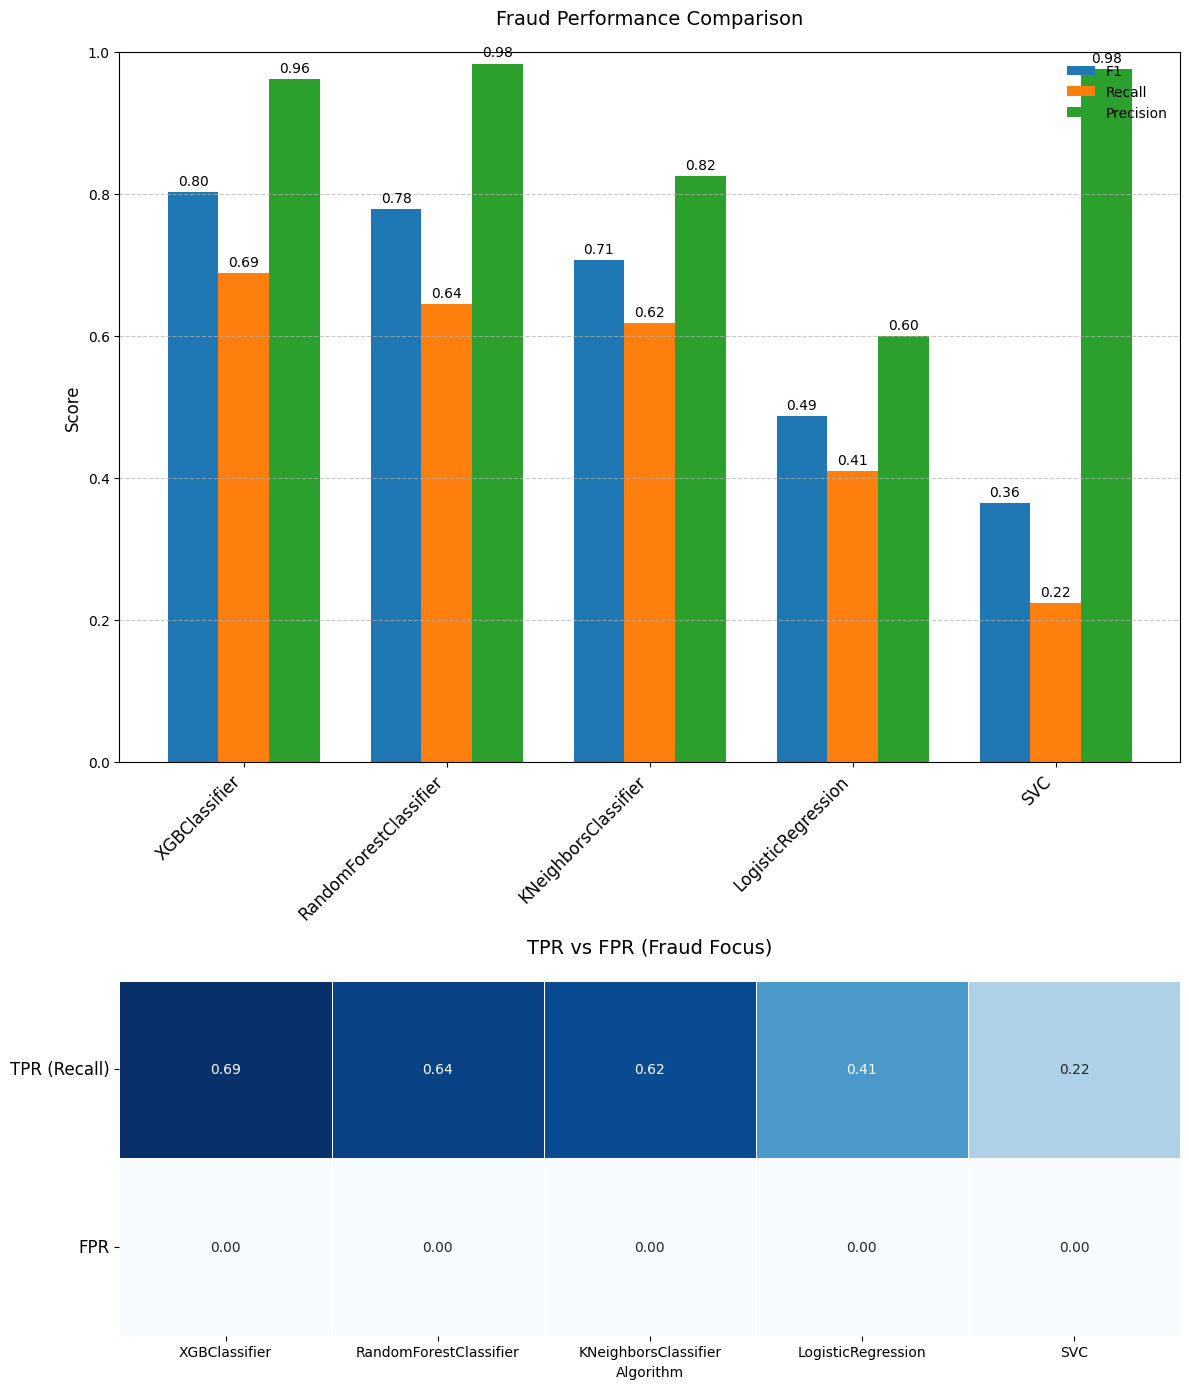

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Sort models by F1 score (Fraud)
models_df = models_df.sort_values('F1 (Fraud)', ascending=False)

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 14), gridspec_kw={'height_ratios': [2, 1]})

# Plot 1: Fraud Metrics Comparison
metrics = ['F1 (Fraud)', 'Recall (Fraud)', 'Precision (Fraud)']
x = np.arange(len(models_df))  # label locations
width = 0.25  # bar width

for idx, metric in enumerate(metrics):
    ax1.bar(x + width*idx, models_df[metric], width, label=metric.replace(' (Fraud)', ''))

ax1.set_title('Fraud Performance Comparison', fontsize=14, pad=20)
ax1.set_ylabel('Score', fontsize=12)
ax1.set_xticks(x + width)
ax1.set_xticklabels(models_df['Algorithm'], rotation=45, ha='right', fontsize=12)
ax1.set_ylim(0, 1)
ax1.legend(loc='upper right', frameon=False)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels
for container in ax1.containers:
    ax1.bar_label(container, fmt='%.2f', padding=3, fontsize=10)

# Plot 2: Confusion Matrix Metrics Heatmap
confusion_metrics = models_df[['Algorithm', 'TP', 'FN', 'FP', 'TN']]
confusion_metrics = confusion_metrics.set_index('Algorithm')

# Calculate rates
confusion_metrics['TPR (Recall)'] = confusion_metrics['TP']/(confusion_metrics['TP'] + confusion_metrics['FN'])
confusion_metrics['FPR'] = confusion_metrics['FP']/(confusion_metrics['FP'] + confusion_metrics['TN'])
confusion_metrics = confusion_metrics[['TPR (Recall)', 'FPR']]

sns.heatmap(confusion_metrics.T, annot=True, fmt=".2f", cmap="Blues",
            ax=ax2, cbar=False, linewidths=.5)
ax2.set_title('TPR vs FPR (Fraud Focus)', fontsize=14, pad=20)
ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0, fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
# Create summary table
summary_df = models_df[['Algorithm', 'F1 (Fraud)', 'Precision (Fraud)',
                       'Recall (Fraud)', 'TP', 'FP']].copy()
summary_df['Fraud Caught'] = summary_df['TP']/summary_df['TP'].sum()
summary_df['False Alarm Rate'] = summary_df['FP']/summary_df['FP'].sum()

print(summary_df.sort_values('F1 (Fraud)', ascending=False))

                Algorithm  F1 (Fraud)  Precision (Fraud)  Recall (Fraud)   TP  \
3           XGBClassifier    0.802548           0.961832        0.688525  126   
2  RandomForestClassifier    0.778878           0.983333        0.644809  118   
1    KNeighborsClassifier    0.706250           0.824818        0.617486  113   
0      LogisticRegression    0.487013           0.600000        0.409836   75   
4                     SVC    0.364444           0.976190        0.224044   41   

   FP  Fraud Caught  False Alarm Rate  
3   5      0.266385          0.060976  
2   2      0.249471          0.024390  
1  24      0.238901          0.292683  
0  50      0.158562          0.609756  
4   1      0.086681          0.012195  


3.2. Grid Search for Best Hyper-Parameter

In the above report we see the best training accuracy is from Random Forest Classifier. On the other hand the best test accuracy is from XGBoost Classifier. We would like to optimize these two model with grid search of multiple parameter values. Grid earch will help me to figure our best parameters to pass to the model to get the most accurate result. We will create a function for grid search named best_param. It will take parameter values and the classifer and print our the best parameter combinations. We will only run Random Forest and XGBoost models for the rest of the project since they are the best two.



In [ ]:
#A general function for grdi search
from sklearn.model_selection import train_test_split, GridSearchCV
def grid_src(classifier, param_grid):
    param_grid=param_grid
    # instantiate the tuned random forest
    grid_search = GridSearchCV(classifier, param_grid, cv=5, n_jobs=-1)

    # train the tuned random forest
    grid_search.fit(X_train, y_train)

    # print best estimator parameters found during the grid search
    print((str(classifier) + 'Best Parameters'))
    print("------------------------")
    print(grid_search.best_params_)
    return grid_search.best_params_

In [ ]:
#Grid Search for best parameters of RandomForestClassifier
param_grid_rf = {'n_estimators': [10, 80, 100],
                  'criterion': ['gini', 'entropy'],
                  'max_depth': [10],
                  'min_samples_split': [2, 3, 4]
                 }

rf_params=grid_src(RandomForestClassifier(),param_grid_rf)

RandomForestClassifier()Best Parameters
------------------------
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 3, 'n_estimators': 80}


In [ ]:
#Grid Search for best parameters of XGBClassifier
param_grid_xg = {'n_estimators': [100],
              'learning_rate': [0.05, 0.1],
              'max_depth': [3, 5, 10],
              'colsample_bytree': [0.7, 1],
              'gamma': [0.0, 0.1, 0.2]
                }
# Update XGBClassifier import statement if necessary
from xgboost import XGBClassifier
grid_src(XGBClassifier(), param_grid_xg) # This code executes grid search using updated XGBoost with potential compatibility issues

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)Best Parameters
------------------------
{'colsample_bytree': 1, 'gamma': 0.2, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 100}


{'colsample_bytree': 1,
 'gamma': 0.2,
 'learning_rate': 0.05,
 'max_depth': 10,
 'n_estimators': 100}

Run models with their best parameters

In [ ]:
#a function to train and evaluate a  model with given datasets
#it also prints the accuracy scores
from sklearn.metrics import roc_auc_score, classification_report
def run_model(model, X_train, y_train,X_test, y_test ):
    model.fit(X_train, y_train)

    # predict
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    # evaluate
    train_accuracy = roc_auc_score(y_train, train_preds)
    test_accuracy = roc_auc_score(y_test, test_preds)
    report = classification_report(y_test, test_preds)

    #print reports of the model accuracy
    print('Model Scores')
    print("------------------------")
    print(f"Training Accuracy: {(train_accuracy * 100):.4}%")
    print(f"Test Accuracy:     {(test_accuracy * 100):.4}%")
    print("------------------------------------------------------")
    print('Classification Report : \n', report)

In [ ]:
# Running RandomForestClassifier with best parameters
rf_model=RandomForestClassifier(n_estimators=80,
                                  criterion= 'entropy',
                                  max_depth= 10,
                                  min_samples_split= 3)


run_model(rf_model, X_train, y_train,X_test, y_test)

Model Scores
------------------------
Training Accuracy: 85.96%
Test Accuracy:     81.97%
------------------------------------------------------
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    114257
           1       0.99      0.64      0.78       183

    accuracy                           1.00    114440
   macro avg       1.00      0.82      0.89    114440
weighted avg       1.00      1.00      1.00    114440



The training and test accuracies for the new model (85.96% and 81.97%) are significantly lower than the initial model's training accuracy (98%) but are closer to each other. This indicates improved generalization and less overfitting, suggesting that the new parameters better balance model complexity with predictive power.



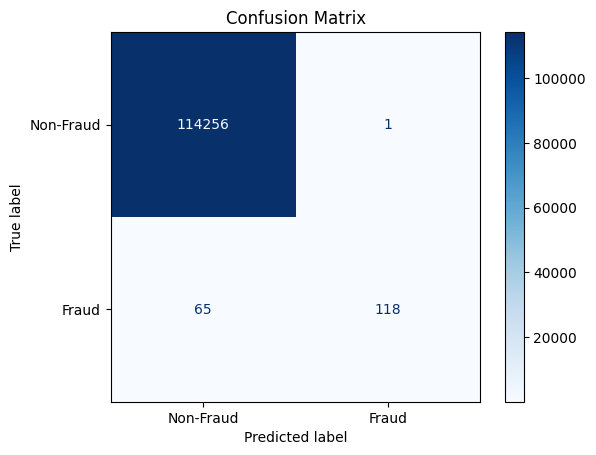

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Run your model and get predictions
rf_model = RandomForestClassifier(n_estimators=80,
                                  criterion='entropy',
                                  max_depth=10,
                                  min_samples_split=3)
rf_model.fit(X_train, y_train)
test_preds = rf_model.predict(X_test)

# Generate confusion matrix
cm = confusion_matrix(y_test, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Fraud', 'Fraud'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

Model Scores
------------------------
Training Accuracy: 91.1%
Test Accuracy:     83.33%
------------------------------------------------------
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    114257
           1       0.97      0.67      0.79       183

    accuracy                           1.00    114440
   macro avg       0.98      0.83      0.89    114440
weighted avg       1.00      1.00      1.00    114440



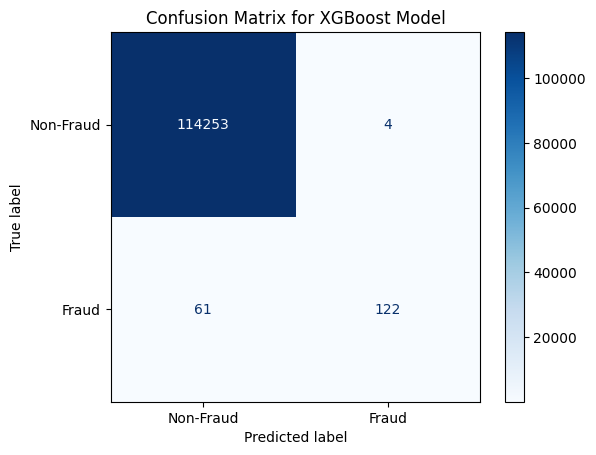

In [ ]:
# Running XGBClassifier with best parameters
xgb_model=XGBClassifier(colsample_bytree= 1,
                        n_estimators= 100,
                        gamma= 0.2,
                        learning_rate=0.05,
                        max_depth=10
                        )

run_model(xgb_model, X_train, y_train,X_test, y_test)


# Train the model
xgb_model.fit(X_train, y_train)

# Predict on the test set
test_preds = xgb_model.predict(X_test)

# Generate confusion matrix
cm = confusion_matrix(y_test, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Fraud', 'Fraud'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for XGBoost Model')
plt.show()

The new training accuracy (91.1%) is significantly lower than the initial model, indicating that the model is avoiding overfitting by not memorizing the training data. The test accuracy (83.33%) is close to the training accuracy, which is a good indication of a balanced performance.

Randomforest classifier might be effected the skewness of the target. Our data is quite unbalanced. That skewness can be taken care by resampling the data via SMOTE.

3.3. Dealing with Unbalanced Data

3.3.1. Balancing Data via Oversampling with SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

# View previous class distribution
print(X.value_counts())

# Resample data ONLY using training data
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# View synthetic sample class distribution
print(pd.Series(y_resampled).value_counts())


Old Balance Org  New Balance Orig  Amount in Birr  Account Type  Old Balance Held Dest  Balance Held Dest  Transaction Hour  Transaction Type_CASH_OUT  Transaction Type_DEBIT  Transaction Type_PAYMENT  Transaction Type_TRANSFER  Conducting Manner_Cash  Conducting Manner_Internet Banking  Conducting Manner_Mobile Banking  Sex_MALE  Transaction Day  Age
38600000.0       38900000.0        376022.62       0             1812980.49             1720832.30         14                0                          0                       0                         0                          0                       0                                   0                                 0         6                30     1
0.0              0.0               55091.17        46            1452485.17             1507576.34         13                1                          0                       0                         0                          1                       0                                 

In [ ]:
# perform  train-test-split over resampled data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, random_state=0)

Running models with the balanced data with best parameters

Model Scores
------------------------
Training Accuracy: 99.03%
Test Accuracy:     99.03%
------------------------------------------------------
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      0.99      0.99    114670
           1       0.99      1.00      0.99    113843

    accuracy                           0.99    228513
   macro avg       0.99      0.99      0.99    228513
weighted avg       0.99      0.99      0.99    228513



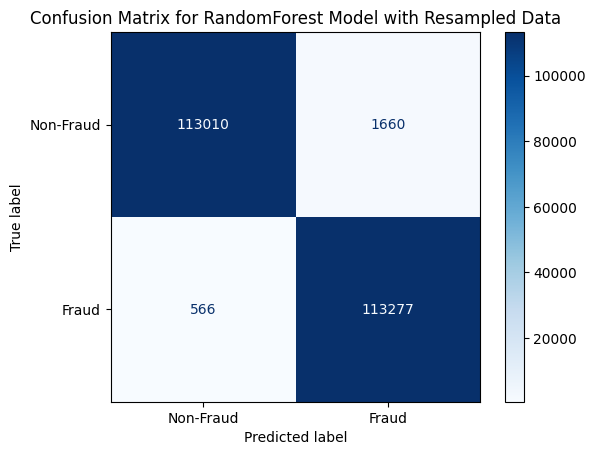

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Running RandomForest model with resampled data
run_model(rf_model, X_train, y_train, X_test, y_test)

# Generate and display the confusion matrix
test_preds = rf_model.predict(X_test)
cm = confusion_matrix(y_test, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Fraud', 'Fraud'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for RandomForest Model with Resampled Data')
plt.show()

Model Scores
------------------------
Training Accuracy: 99.85%
Test Accuracy:     99.82%
------------------------------------------------------
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    114670
           1       1.00      1.00      1.00    113843

    accuracy                           1.00    228513
   macro avg       1.00      1.00      1.00    228513
weighted avg       1.00      1.00      1.00    228513



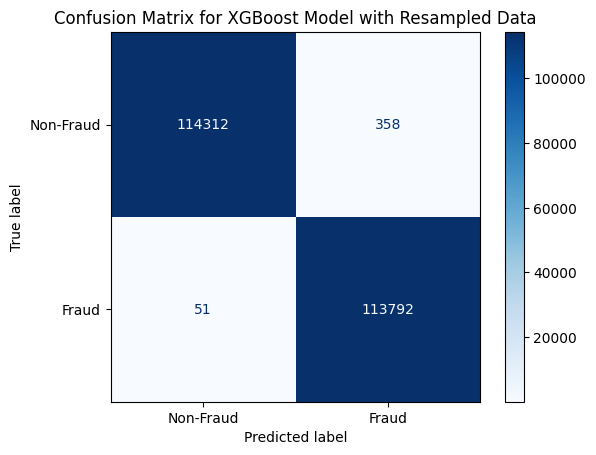

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Running XGBoost model with resampled data
run_model(xgb_model, X_train, y_train, X_test, y_test)

# Generate and display the confusion matrix
test_preds = xgb_model.predict(X_test)
cm = confusion_matrix(y_test, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Fraud', 'Fraud'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for XGBoost Model with Resampled Data')
plt.show()

Both models (Random Forest and XGBoost) show exceptionally high training and test accuracies after applying SMOTE, suggesting that balancing the dataset improved their ability to generalize from training data to unseen test data.

3.3.2. Subsampling Data from the Original Dataset

We had a huge dataset at the beginning and we did random sampling to reduce the computational laod. But we have a lot more natural fraud data point in this dataset that we can use. Insted of creating syntetic data we will choose those pints and randomly choose the safe transaction data points to get less skewed sample for my models.

In [ ]:
# Slice data into fraud and safe by isFraud values
safe_2 = data[data['is Fraud'] == 0]
fraud_2 = data[data['is Fraud'] == 1]

# Get 50,000 random samples from the safe transactions
safe_sample = safe_2.sample(n=50000, random_state=1)
safe_sample = safe_sample.sort_index()
safe_samplef = safe_sample.reset_index(drop=True)

# Combine all fraud observations and 50,000 safe transaction data into df3
df3 = pd.concat([safe_sample, fraud_2])
df3.reset_index(drop=True)

df3.head()


,Old Balance Org,New Balance Orig,Amount in Birr,Account Type,Old Balance Held Dest,Balance Held Dest,is Fraud,Transaction Hour,Transaction Type_CASH_OUT,Transaction Type_DEBIT,Transaction Type_PAYMENT,Transaction Type_TRANSFER,Conducting Manner_Cash,Conducting Manner_Internet Banking,Conducting Manner_Mobile Banking,Sex_MALE,Transaction Day,Age
9,0.0,0.0,77957.68,46,94900.0,22233.65,0,10,0,0,0,1,1,0,0,1,6,40
13,0.0,0.0,379856.23,46,900180.0,19200000.00,0,14,0,0,0,1,1,0,0,1,6,42
14,0.0,0.0,1505626.01,19,29031.0,5515763.34,0,18,0,0,0,1,1,0,0,1,6,35
53,0.0,0.0,114712.48,46,145400.0,0.00,0,9,1,0,0,0,1,0,0,1,6,31
61,0.0,0.0,80311.89,46,87408.0,63112.23,0,11,1,0,0,0,1,0,0,1,6,33


In [ ]:
#check class labels
df3['is Fraud'].value_counts()

,count
is Fraud,
0,50000
1,913


The new dataset with totally natural data is ready for going in to our models. The proportion is still not 50% but good enough to train a model.

Running models with subsampled organic data


In [ ]:
#Slice the target and features from the dataset
features2=df3.drop('is Fraud', axis=1)
target2 =df3['is Fraud']
# split the data into train and test
X_train2, X_test2, y_train2, y_test2 = train_test_split(features2, target2, test_size=0.2)

Model Scores
------------------------
Training Accuracy: 90.76%
Test Accuracy:     85.71%
------------------------------------------------------
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     10001
           1       0.99      0.71      0.83       182

    accuracy                           0.99     10183
   macro avg       0.99      0.86      0.91     10183
weighted avg       0.99      0.99      0.99     10183



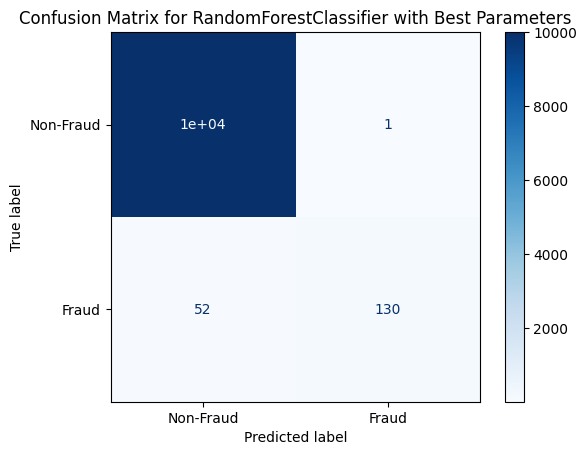

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Running RandomForestClassifier with best parameters
run_model(rf_model, X_train2, y_train2, X_test2, y_test2)

# Generate and display the confusion matrix
test_preds = rf_model.predict(X_test2)
cm = confusion_matrix(y_test2, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Fraud', 'Fraud'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for RandomForestClassifier with Best Parameters')
plt.show()

Model Scores
------------------------
Training Accuracy: 98.42%
Test Accuracy:     91.72%
------------------------------------------------------
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     10001
           1       0.96      0.84      0.89       182

    accuracy                           1.00     10183
   macro avg       0.98      0.92      0.94     10183
weighted avg       1.00      1.00      1.00     10183



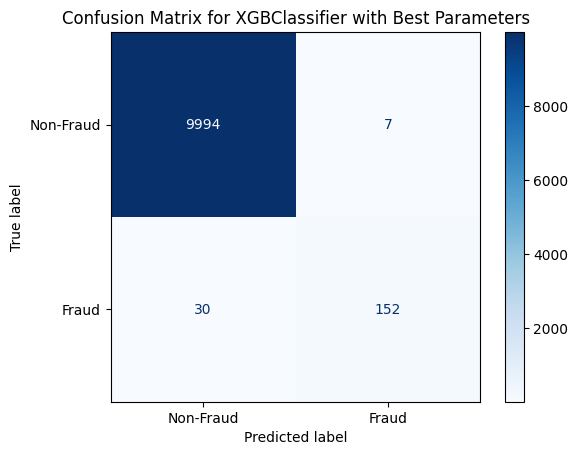

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Running XGBClassifier with best parameters
run_model(xgb_model, X_train2, y_train2, X_test2, y_test2)

# Generate and display the confusion matrix
test_preds = xgb_model.predict(X_test2)
cm = confusion_matrix(y_test2, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Fraud', 'Fraud'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for XGBClassifier with Best Parameters')
plt.show()


Both models benefit from the balanced dataset. The Random Forest classifier has lower accuracy compared to XGBoost. The higher variances in Random Forest accuracy may suggest less stability in learning patterns due to the inherent randomness in the algorithm.


3.3.3 Performing SMOTE on the New Data

In [ ]:
from imblearn.over_sampling import SMOTE

# view previous class distribution
print(target2.value_counts())

# resample data ONLY using training data
X_resampled2, y_resampled2 = SMOTE().fit_resample(X_train2, y_train2)


# view synthetic sample class distribution
print(pd.Series(y_resampled2).value_counts())
X_train2, X_test2, y_train2, y_test2 = train_test_split(features2, target2, test_size=0.2)

is Fraud
0    50000
1      913
Name: count, dtype: int64
is Fraud
0    39999
1    39999
Name: count, dtype: int64


Running models with subsampled and oversampled data

Model Scores
------------------------
Training Accuracy: 87.57%
Test Accuracy:     85.88%
------------------------------------------------------
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     10006
           1       1.00      0.72      0.84       177

    accuracy                           1.00     10183
   macro avg       1.00      0.86      0.92     10183
weighted avg       1.00      1.00      0.99     10183



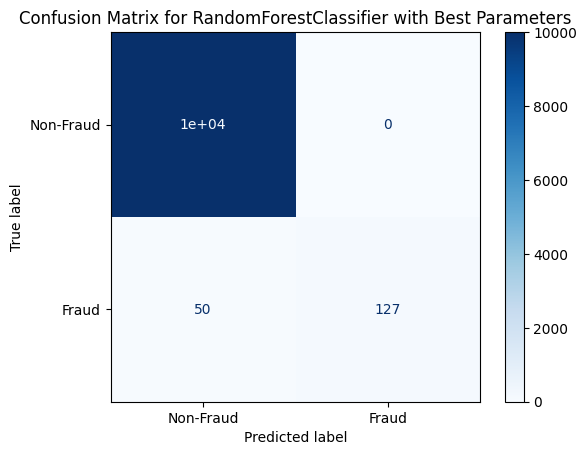

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Running RandomForestClassifier with best parameters
run_model(rf_model, X_train2, y_train2, X_test2, y_test2)

# Generate and display the confusion matrix
test_preds = rf_model.predict(X_test2)
cm = confusion_matrix(y_test2, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Fraud', 'Fraud'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for RandomForestClassifier with Best Parameters')
plt.show()

Model Scores
------------------------
Training Accuracy: 87.02%
Test Accuracy:     85.88%
------------------------------------------------------
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     10006
           1       1.00      0.72      0.84       177

    accuracy                           1.00     10183
   macro avg       1.00      0.86      0.92     10183
weighted avg       1.00      1.00      0.99     10183

AUC-ROC Score: 0.9978


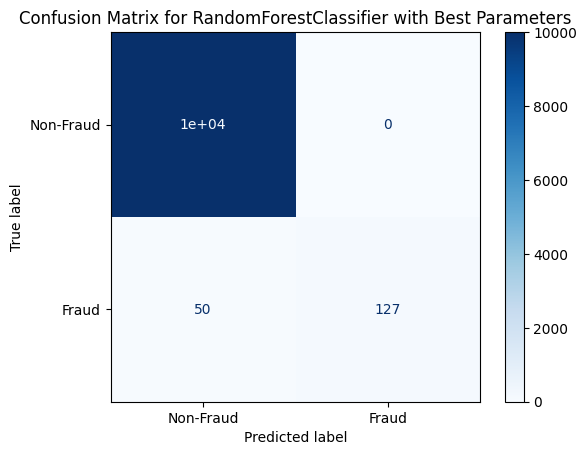

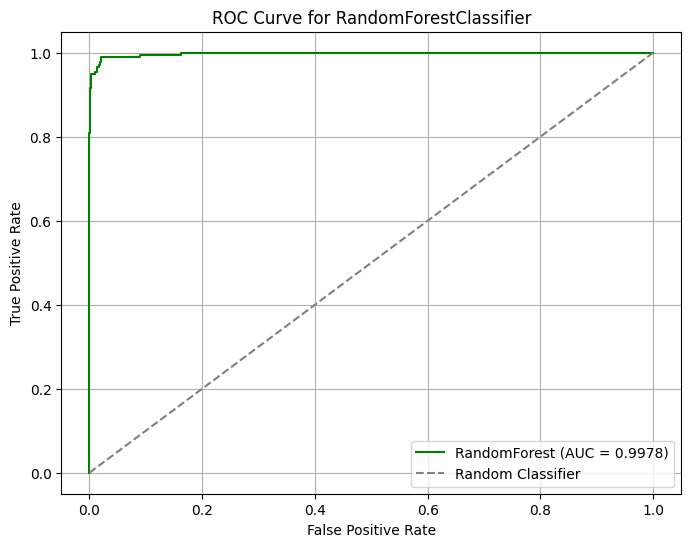

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay

# Run the model (assumes run_model trains rf_model)
run_model(rf_model, X_train2, y_train2, X_test2, y_test2)

# Predict probabilities for ROC curve
y_probs = rf_model.predict_proba(X_test2)[:, 1]  # Get probability of Fraud
y_pred = rf_model.predict(X_test2)

# Calculate AUC-ROC score
auc_roc = roc_auc_score(y_test2, y_probs)
print(f"AUC-ROC Score: {auc_roc:.4f}")

# Generate and display the confusion matrix
cm = confusion_matrix(y_test2, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Fraud', 'Fraud'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for RandomForestClassifier with Best Parameters')
plt.show()

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test2, y_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='green', label=f'RandomForest (AUC = {auc_roc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Classifier')  # Baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for RandomForestClassifier')
plt.legend()
plt.grid()
plt.show()


Model Scores
------------------------
Training Accuracy: 98.44%
Test Accuracy:     93.77%
------------------------------------------------------
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     10006
           1       0.97      0.88      0.92       177

    accuracy                           1.00     10183
   macro avg       0.99      0.94      0.96     10183
weighted avg       1.00      1.00      1.00     10183



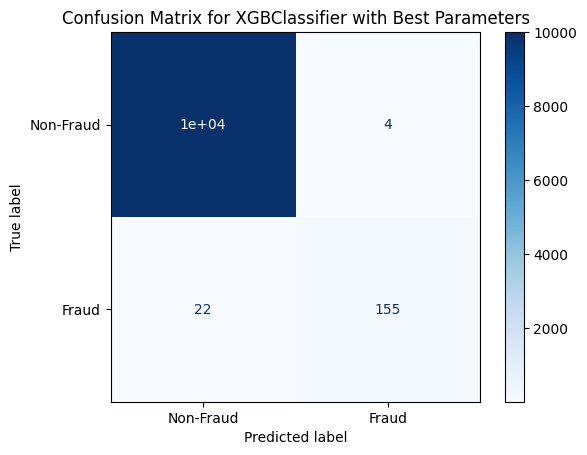

In [ ]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Running XGBClassifier with best parameters
run_model(xgb_model, X_train2, y_train2, X_test2, y_test2)

# Generate and display the confusion matrix
test_preds = xgb_model.predict(X_test2)
cm = confusion_matrix(y_test2, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Fraud', 'Fraud'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for XGBClassifier with Best Parameters')
plt.show()

Model Scores
------------------------
Training Accuracy: 98.44%
Test Accuracy:     93.77%
------------------------------------------------------
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     10006
           1       0.97      0.88      0.92       177

    accuracy                           1.00     10183
   macro avg       0.99      0.94      0.96     10183
weighted avg       1.00      1.00      1.00     10183

AUC-ROC Score: 0.9995


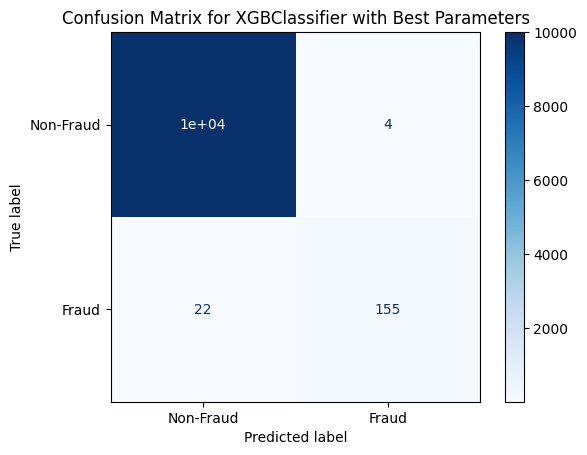

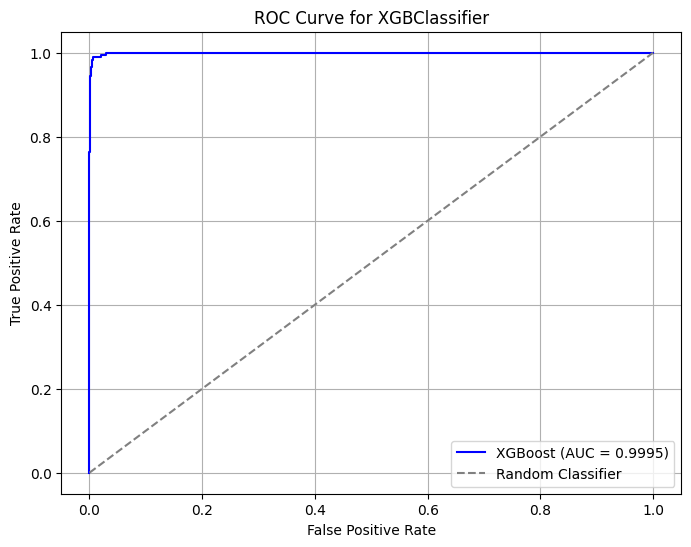

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay

# Run the model (assumes run_model trains xgb_model)
run_model(xgb_model, X_train2, y_train2, X_test2, y_test2)

# Predict probabilities for ROC curve
y_probs = xgb_model.predict_proba(X_test2)[:, 1]  # Get probability of Fraud
y_pred = xgb_model.predict(X_test2)

# Calculate AUC-ROC score
auc_roc = roc_auc_score(y_test2, y_probs)
print(f"AUC-ROC Score: {auc_roc:.4f}")

# Generate and display the confusion matrix
cm = confusion_matrix(y_test2, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Fraud', 'Fraud'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for XGBClassifier with Best Parameters')
plt.show()

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test2, y_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'XGBoost (AUC = {auc_roc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Classifier')  # Baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBClassifier')
plt.legend()
plt.grid()
plt.show()


The Random Forest model displays good training accuracy but lower test accuracy, which indicates some degree of overfitting or variance in the model performance.
On the other hand, XGBoost exhibits a more favorable performance profile with a high test accuracy, which is closer to its training accuracy, suggesting better generalization.

4. Machine Learning Pipeline

Pipelines are extremely useful tools to write clean and manageable code for machine learning.Creating a model takes a many steps such as clean our data, transform it, potentially use feature selection, and then run a machine learning algorithm. Using pipelines, we can do all these steps in one go!

In [ ]:
#Load necessary libraries for ml pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

Best accuracy: 0.964

Best params:
 {'xgb__colsample_bytree': 1, 'xgb__gamma': 0.1, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 10, 'xgb__n_estimators': 100}


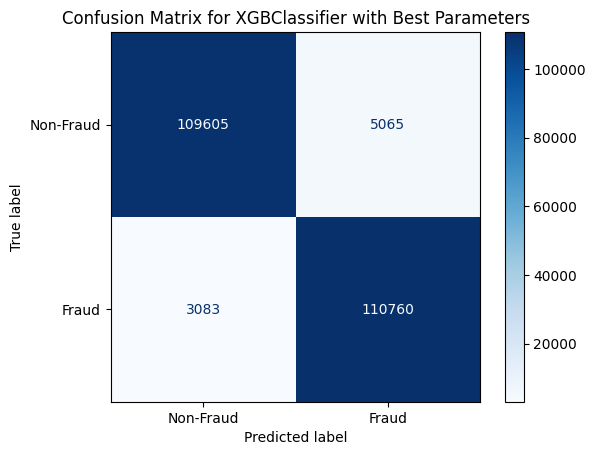

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create the pipeline
pipe = Pipeline([('scl', MinMaxScaler()),
                ('pca', PCA(n_components=7)),
                ('xgb', XGBClassifier())])

# Create the grid parameter
grid = [{'xgb__n_estimators': [100],
         'xgb__learning_rate': [0.05, 0.1],
         'xgb__max_depth': [3, 5, 10],
         'xgb__colsample_bytree': [0.7, 1],
         'xgb__gamma': [0.0, 0.1, 0.2]
                }]

# Create the grid, with "pipe" as the estimator
gridsearch = GridSearchCV(estimator=pipe,
                  param_grid=grid,
                  scoring='accuracy',
                  cv=5)

# Fit using grid search
gridsearch.fit(X_train, y_train)

# Best accuracy
print('Best accuracy: %.3f' % gridsearch.best_score_)

# Best params
print('\nBest params:\n', gridsearch.best_params_)

# Predict using the best model
best_model = gridsearch.best_estimator_
y_pred = best_model.predict(X_test)

# Generate and display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Fraud', 'Fraud'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for XGBClassifier with Best Parameters')
plt.show()

The model achieved a best accuracy of 96.4%, indicating strong predictive performance. The optimal parameters include a maximum depth of 10, a learning rate of 0.1, and 100 estimators, with a full column sample and 0.1 gamma regularization, suggesting a robust configuration for the XGBoost algorithm.

The value 0.964 means that the model achieved an accuracy of 96.4% on average when evaluated using 5-fold cross-validation on the training data. It shows how well the model performed during training with the chosen hyperparameters.

5. Feature Importance

Lets check whick features are the most influencial ones for both model.

In [ ]:
# Check the number of features in the model and the DataFrame
print(f"Number of features in model: {len(rf_model.feature_importances_)}")
print(f"Number of columns in features DataFrame: {len(X.columns)}")

Number of features in model: 17
Number of columns in features DataFrame: 17


Text(0.5, 1.0, 'Feature Importance Order')

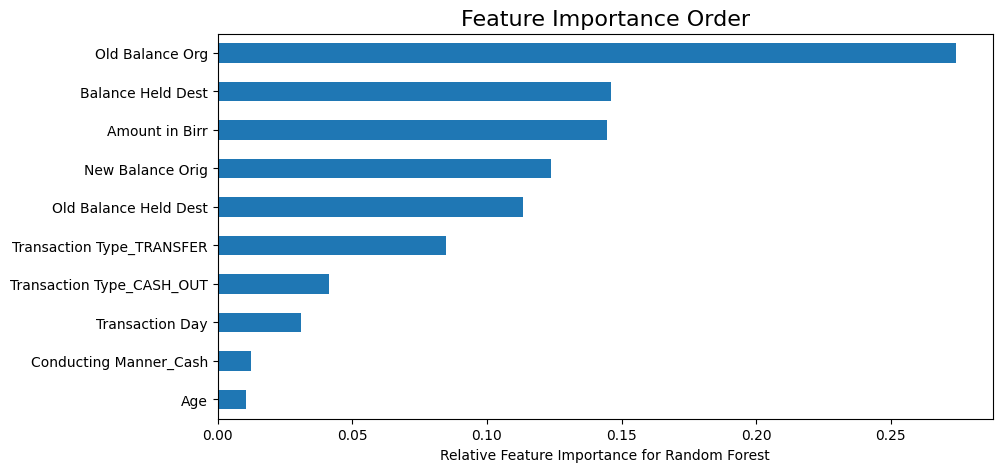

In [ ]:
# Align the columns if there are more features in the model than in the DataFrame
aligned_columns = X.columns[:len(rf_model.feature_importances_)]  # Make sure it matches

# Create the feature importance series with aligned columns
feat_importances = pd.Series(rf_model.feature_importances_, index=aligned_columns)

# Now plot the important features
ax.set_ylabel('features', size=16)
feat_importances.nlargest(10).sort_values().plot(kind='barh', figsize=(10, 5))
plt.xlabel('Relative Feature Importance for Random Forest')
plt.title('Feature Importance Order', size=16)


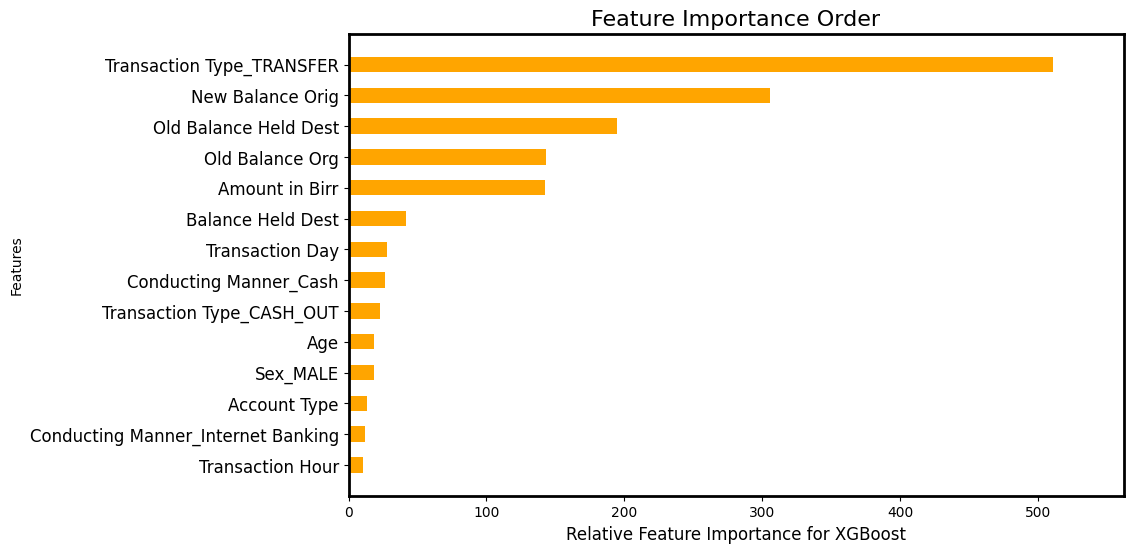

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

# Plot the feature importance for XGBoost
plot_importance(xgb_model,
                height=0.5,
                color='orange',
                grid=False,
                show_values=False,
                importance_type='cover',
                ax=ax)

# Customize the plot
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)

ax.set_xlabel('Relative Feature Importance for XGBoost', size=12)
ax.set_yticklabels(ax.get_yticklabels(), size=12)
ax.set_title('Feature Importance Order', size=16)

# Show the plot
plt.show()


The feature importance chart for XGBoost indicates that "New Balance Orig" is the most influential feature in predicting outcomes, followed closely by "Old Balance Held Dest" and "Old Balance Org." These findings suggest that balance-related features play a critical role in the model's decision-making process, highlighting the importance of financial figures in the dataset. This insight can guide further analysis or model refinement by focusing on these key features.

6. Conclusion

Accuracy results after iterations

We created a model that can predict fraud transactions. We used XGBoost and RandomForest classifiers in this model.

  (Data & Parameters)                                                (Accuracy)   
                                                             RandomForest     XGBoost

  **Iteration 1**                                                            
- Random Sample & default parameters                                85.06%    87.35%               
 **Iteration 2**
- Random Sample & best parameters                                   84.48%     87.35%
  **Iteration 3**
- Balanced data with SMOTE & best parameters                        99.8%     99.98%
  **Iteration 4**
- Random Safe trans. data and all Fraud data & best parameters      87.7%     94.33%
  **Iteration 5**
- New data balanced with SMOTE & best parameters                    86.88%     94.05%

Most Influential Features
Most important features are  senders balance after the transaction (New Balance Orig) and  receivers balance after the transaction (Old Balance Held Dest).

7.Future Work

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import pickle

# Define your pipeline
pipe = Pipeline([('scl', MinMaxScaler()),
                 ('pca', PCA(n_components=7)),
                 ('xgb', XGBClassifier())])

# Define your grid of hyperparameters
grid = [{'xgb__n_estimators': [100],
         'xgb__learning_rate': [0.05, 0.1],
         'xgb__max_depth': [3, 5, 10],
         'xgb__colsample_bytree': [0.7, 1],
         'xgb__gamma': [0.0, 0.1, 0.2]
        }]

# Perform GridSearchCV
gridsearch = GridSearchCV(estimator=pipe, param_grid=grid, scoring='accuracy', cv=5)

# Fit the grid search to your training data
gridsearch.fit(X_train, y_train)

# Extract the best model
best_model = gridsearch.best_estimator_

# Save the best model to a file
with open('best_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

print('Model saved successfully.')


Model saved successfully.


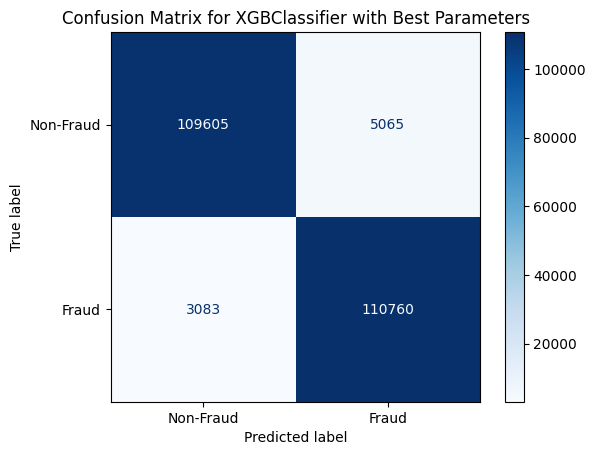

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load the best model
with open('best_model.pkl', 'rb') as file:
    best_model = pickle.load(file)

# Predict using the best model
y_pred = best_model.predict(X_test)

# Generate and display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Fraud', 'Fraud'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for XGBClassifier with Best Parameters')
plt.show()

AUC-ROC Score: 0.9945


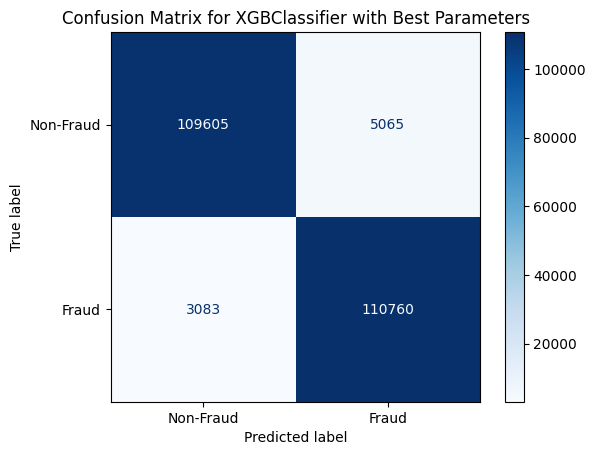

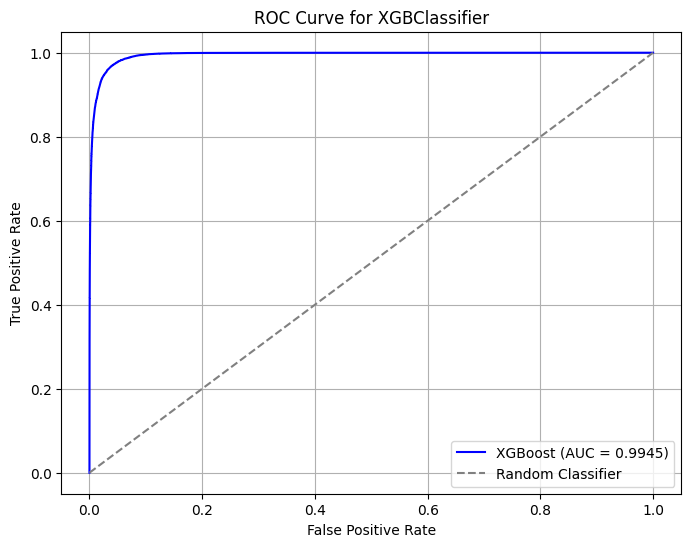

In [ ]:
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay

# Load the best model
with open('best_model.pkl', 'rb') as file:
    best_model = pickle.load(file)

# Predict probabilities for ROC curve
y_probs = best_model.predict_proba(X_test)[:, 1]  # Get probability of class 1 (Fraud)
y_pred = best_model.predict(X_test)

# Calculate AUC-ROC score
auc_roc = roc_auc_score(y_test, y_probs)
print(f"AUC-ROC Score: {auc_roc:.4f}")

# Generate and display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Fraud', 'Fraud'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for XGBClassifier with Best Parameters')
plt.show()

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'XGBoost (AUC = {auc_roc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Classifier')  # Baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBClassifier')
plt.legend()
plt.grid()
plt.show()


In [ ]:
import pickle
import numpy as np

# Load the model from the file
with open('best_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# Make predictions
predictions = loaded_model.predict(X_test)

# Assuming you have defined the trained classifier 'classifier'

input_data = [
    1, 1, 0, 0, 80311.89, 1, 46, 87408, 63112.23, 11, 6, 32, 1, 1, 0, 0, 0
]

# Convert non-numeric values to a consistent format (e.g., '0' or 0)
processed_data = []
for value in input_data:
    if isinstance(value, str) and not value.isnumeric():
        processed_data.append(0)
    else:
        processed_data.append(value)

# Convert the processed data to a numpy array
input_data_as_numpy_array = np.asarray(processed_data)

# Reshape the numpy array as we are predicting for only one instance
input_data_reshaped = input_data_as_numpy_array.reshape(1, -1)

# Make prediction using the loaded model
prediction = loaded_model.predict(input_data_reshaped)
print(prediction)

# Interpret the result
if prediction[0] == 0:
    print('Not a fraudulent transaction')
else:
    print('Fraudulent transaction')


[0]
Not a fraudulent transaction


In [ ]:

# Perform predictions on the test set
y_pred = best_model.predict(X_test)

# If you need the probability estimates, you can use:
# y_proba = best_model.predict_proba(X_test)

# Print the first few predictions (for demonstration purposes)
print('Predictions:\n', y_pred[:100])

# Optionally, print the predicted probabilities for the first few samples
# print('Predicted Probabilities:\n', y_proba[:10])


Predictions:
 [0 0 1 0 1 0 1 0 1 0 0 1 0 1 1 1 0 1 0 1 1 0 1 1 0 0 1 1 1 1 1 0 1 1 0 1 1
 1 0 1 0 1 1 1 0 1 1 0 1 0 1 1 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 1 1 0 1 1 1
 0 0 0 1 0 1 1 0 1 1 0 1 0 0 1 0 0 1 0 0 1 1 1 0 1 0]


In [ ]:
import pickle

with open('best_model.pkl', 'rb') as file:
    content = pickle.load(file)
    print(type(content))
    print(content)


<class 'sklearn.pipeline.Pipeline'>
Pipeline(steps=[('scl', MinMaxScaler()), ('pca', PCA(n_components=7)),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0.1, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=10, max_leaves=None,
                               min_child_weight=None, missing=nan,
                            

Best accuracy: 0.964

Best params:
 {'xgb__colsample_bytree': 1, 'xgb__gamma': 0.1, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 10, 'xgb__n_estimators': 100}


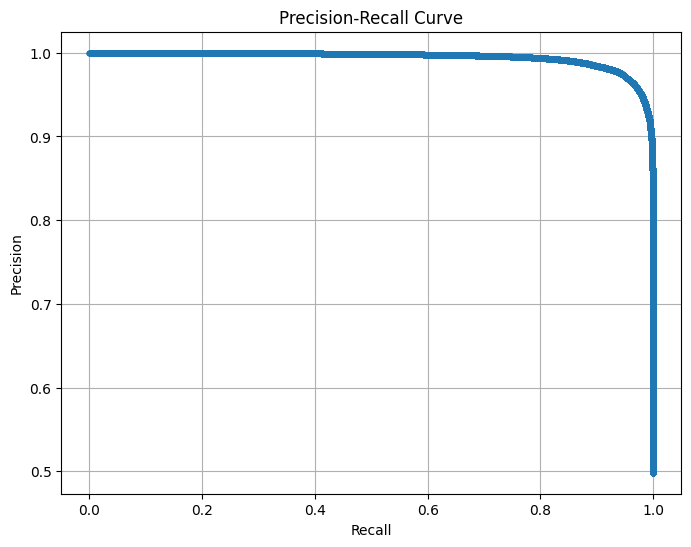

Average Precision Score: 0.99


In [ ]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import pickle

# Example data preparation
# X_train, y_train, X_test, y_test should be defined

# Create the pipeline
pipe = Pipeline([
    ('scl', MinMaxScaler()),
    ('pca', PCA(n_components=7)),
    ('xgb', XGBClassifier())
])

# Create the grid parameter
grid = [{'xgb__n_estimators': [100],
         'xgb__learning_rate': [0.05, 0.1],
         'xgb__max_depth': [3, 5, 10],
         'xgb__colsample_bytree': [0.7, 1],
         'xgb__gamma': [0.0, 0.1, 0.2]
        }]

# Create the grid search
gridsearch = GridSearchCV(estimator=pipe,
                          param_grid=grid,
                          scoring='accuracy',
                          cv=5)

# Fit using grid search
gridsearch.fit(X_train, y_train)

# Print best accuracy and parameters
print('Best accuracy: %.3f' % gridsearch.best_score_)
print('\nBest params:\n', gridsearch.best_params_)

# Get the best model from the grid search
best_model = gridsearch.best_estimator_

# Get predicted probabilities for the positive class
y_probs = best_model.predict_proba(X_test)[:, 1]

# Compute precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

# Calculate and print average precision score
average_precision = average_precision_score(y_test, y_probs)
print(f'Average Precision Score: {average_precision:.2f}')


In [ ]:
import pickle

# Load the saved model
with open('best_model.pkl', 'rb') as file:
    content = pickle.load(file)

# Check the type of the content
print(type(content))  # Should be <class 'sklearn.pipeline.Pipeline'> or similar




<class 'sklearn.pipeline.Pipeline'>


In [ ]:
print(loaded_model.named_steps)  # Shows the steps in the pipeline

{'scl': MinMaxScaler(), 'pca': PCA(n_components=7), 'xgb': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)}


In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# List of account types used
account_types = [
    'WADIAH CURRENT', 'SAV INT BEARING', 'SPECIAL SAVINGS', 'WADIAH SAVING', 'CURRENT ACCOUNT',
    'Fitayah Savings', 'Wadiah Special', 'APOLLO', 'ADEY SAVING', 'FCY Prepaid tra',
    'Zahrah Savings', 'AFLA SAVING', 'Musnin Savings', 'BALEWUL SAVING', 'Foreign cur sav',
    'MUDAY ABYS', 'HAJJ SAVING ACC', 'Spec.Large IQUB', 'AMEEN GOAL SAVI', 'Wadiah Muday Sa',
    'STAFF ORDI SAVI', 'WADIHA IQUUB', 'MIN SAV INT BEA', 'Large IQUB', 'ASRAT BEKURAT',
    'Wadiah Educatio', 'EDUCATION SAV', 'NON-RES FCY AC', 'AMEEN GOAL S -M', 'SAVING PLUS',
    'STAFF WADIYA', 'Medium IQUB', 'Small Size IQUB', 'WADIAH YAD DHAM', 'DD NR FCY- DIAS',
    'SALARY ADV', 'MUDARABA SAVING', 'IDDR a', 'ZEKAT WADIA SAV', 'PROV EMP CON', 'Staff Women',
    'MUDARABA ZAHRAH', 'MIN SAV IFB', 'SAV NON-INT', 'STAFF SPEC SAVI', 'NRT Account', 'NRNT ACCOUNT',
    'MORTGAGE.LN', 'Private Pens', 'SPEC SAVI DEPO', 'Ret Main a/c', 'ECX PAYO-CLIENT', 'VEHICLE.LNS',
    'Saving Diaspora', 'PL.CONSU.LOAN', 'ECX PAYIN CLIEN', 'GOV PENSION', 'STAFF.MORG.LN',
    'ZEKAT WADIAH SA', 'MUDARABA MUSNIN', 'MUDARABA FITAYA', 'TEEN YOUTH SAV', 'ECX payin non-m',
    'STAFF ZEHA SAVI', 'STAF.PL.CNSULN', 'TENORED.WC.SME', 'DIAS MORTGAGE', 'EXP.ADV.SAL.COR',
    'HOT&SER.PR.SME', 'TENORED.WC.COR', 'WAD SAV- FCY AC', 'Wadiah Diaspora', 'DIAS MORTG SAV',
    'Loan Related Ex', 'ECX payin MEMB', 'Investment H/U', 'ECXpayout non-m', 'Wadiah Retentio',
    'SPL.PUR.VEH.SME'
]

# Initialize the LabelEncoder
encoder = LabelEncoder()

# Fit the encoder on the full list of account types
encoder.fit(account_types)

# Check the mapping of the account types to their respective numerical labels
account_type_mapping = dict(zip(encoder.classes_, range(len(encoder.classes_))))
print(f"Account Type Mapping: {account_type_mapping}")

# Assuming your data is in a DataFrame 'data' and the column is 'Account Type'
# Example:
data = pd.DataFrame({
    'Account Type': ['WADIAH CURRENT', 'SAV INT BEARING', 'MUDARABA SAVING', 'STAFF ORDI SAVI']
})

# Encode the 'Account Type' column using the fitted encoder
data['Account Type Encoded'] = encoder.transform(data['Account Type'])

# Display the encoded data
print(data)


Account Type Mapping: {'ADEY SAVING': 0, 'AFLA SAVING': 1, 'AMEEN GOAL S -M': 2, 'AMEEN GOAL SAVI': 3, 'APOLLO': 4, 'ASRAT BEKURAT': 5, 'BALEWUL SAVING': 6, 'CURRENT ACCOUNT': 7, 'DD NR FCY- DIAS': 8, 'DIAS MORTG SAV': 9, 'DIAS MORTGAGE': 10, 'ECX PAYIN CLIEN': 11, 'ECX PAYO-CLIENT': 12, 'ECX payin MEMB': 13, 'ECX payin non-m': 14, 'ECXpayout non-m': 15, 'EDUCATION SAV': 16, 'EXP.ADV.SAL.COR': 17, 'FCY Prepaid tra': 18, 'Fitayah Savings': 19, 'Foreign cur sav': 20, 'GOV PENSION': 21, 'HAJJ SAVING ACC': 22, 'HOT&SER.PR.SME': 23, 'IDDR a': 24, 'Investment H/U': 25, 'Large IQUB': 26, 'Loan Related Ex': 27, 'MIN SAV IFB': 28, 'MIN SAV INT BEA': 29, 'MORTGAGE.LN': 30, 'MUDARABA FITAYA': 31, 'MUDARABA MUSNIN': 32, 'MUDARABA SAVING': 33, 'MUDARABA ZAHRAH': 34, 'MUDAY ABYS': 35, 'Medium IQUB': 36, 'Musnin Savings': 37, 'NON-RES FCY AC': 38, 'NRNT ACCOUNT': 39, 'NRT Account': 40, 'PL.CONSU.LOAN': 41, 'PROV EMP CON': 42, 'Private Pens': 43, 'Ret Main a/c': 44, 'SALARY ADV': 45, 'SAV INT BEARING'

In [ ]:
conducting_manner_mapping = {
    'Account to Account': 0,
    'Cash': 1,
    'Internet Banking': 2,
    'Mobile Banking': 3
}


In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# List of account types used
Conducting_Manner = [
    'n MEMB', 'Investment H/U', 'ECXpayout non-m', 'Wadiah Retentio',
    'SPL.PUR.VEH.SME'
]

# Initialize the LabelEncoder
encoder = LabelEncoder()

# Fit the encoder on the full list of account types
encoder.fit(account_types)

# Check the mapping of the account types to their respective numerical labels
account_type_mapping = dict(zip(encoder.classes_, range(len(encoder.classes_))))
print(f"Account Type Mapping: {account_type_mapping}")

# Assuming your data is in a DataFrame 'data' and the column is 'Account Type'
# Example:
data = pd.DataFrame({
    'Account Type': ['WADIAH CURRENT', 'SAV INT BEARING', 'MUDARABA SAVING', 'STAFF ORDI SAVI']
})

# Encode the 'Account Type' column using the fitted encoder
data['Account Type Encoded'] = encoder.transform(data['Account Type'])

# Display the encoded data
print(data)

Account Type Mapping: {'ADEY SAVING': 0, 'AFLA SAVING': 1, 'AMEEN GOAL S -M': 2, 'AMEEN GOAL SAVI': 3, 'APOLLO': 4, 'ASRAT BEKURAT': 5, 'BALEWUL SAVING': 6, 'CURRENT ACCOUNT': 7, 'DD NR FCY- DIAS': 8, 'DIAS MORTG SAV': 9, 'DIAS MORTGAGE': 10, 'ECX PAYIN CLIEN': 11, 'ECX PAYO-CLIENT': 12, 'ECX payin MEMB': 13, 'ECX payin non-m': 14, 'ECXpayout non-m': 15, 'EDUCATION SAV': 16, 'EXP.ADV.SAL.COR': 17, 'FCY Prepaid tra': 18, 'Fitayah Savings': 19, 'Foreign cur sav': 20, 'GOV PENSION': 21, 'HAJJ SAVING ACC': 22, 'HOT&SER.PR.SME': 23, 'IDDR a': 24, 'Investment H/U': 25, 'Large IQUB': 26, 'Loan Related Ex': 27, 'MIN SAV IFB': 28, 'MIN SAV INT BEA': 29, 'MORTGAGE.LN': 30, 'MUDARABA FITAYA': 31, 'MUDARABA MUSNIN': 32, 'MUDARABA SAVING': 33, 'MUDARABA ZAHRAH': 34, 'MUDAY ABYS': 35, 'Medium IQUB': 36, 'Musnin Savings': 37, 'NON-RES FCY AC': 38, 'NRNT ACCOUNT': 39, 'NRT Account': 40, 'PL.CONSU.LOAN': 41, 'PROV EMP CON': 42, 'Private Pens': 43, 'Ret Main a/c': 44, 'SALARY ADV': 45, 'SAV INT BEARING'

In [ ]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pickle

# Create the pipeline with SMOTE
pipe = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('scl', MinMaxScaler()),
    ('pca', PCA(n_components=7)),
    ('xgb', XGBClassifier(random_state=42))
])

# Hyperparameter grid
grid = [{
    'xgb__n_estimators': [100, 200],
    'xgb__learning_rate': [0.05, 0.1],
    'xgb__max_depth': [3, 5],
    'xgb__colsample_bytree': [0.7, 1],
    'xgb__gamma': [0.0, 0.1]
}]

# Grid search with F1-score
gridsearch = GridSearchCV(
    estimator=pipe,
    param_grid=grid,
    scoring='f1',
    cv=3,
    n_jobs=-1
)

# Train the model
gridsearch.fit(X_train, y_train)

# Best model
best_model = gridsearch.best_estimator_

# Save the model
with open('best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Evaluate
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Fraud', 'Fraud'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Optimized for F1-Score)')
plt.show()

              precision    recall  f1-score   support

           0       0.93      0.92      0.93    114504
           1       0.92      0.94      0.93    114005

    accuracy                           0.93    228509
   macro avg       0.93      0.93      0.93    228509
weighted avg       0.93      0.93      0.93    228509

AUC-ROC Score: 0.9820


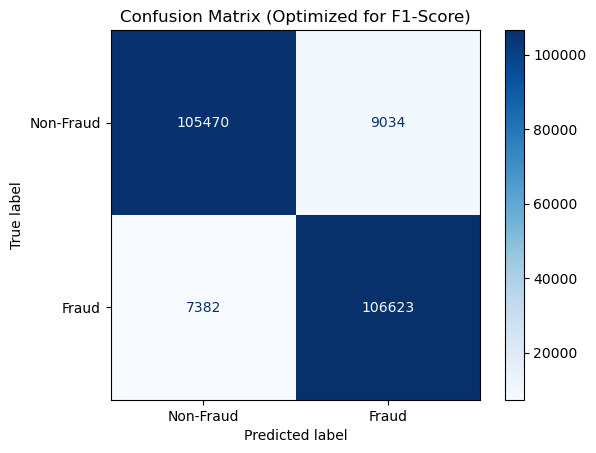

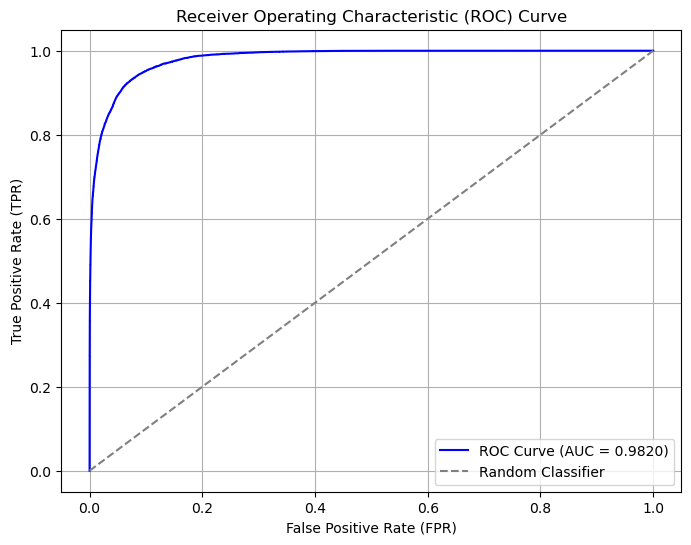

In [ ]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import pickle

# Create the pipeline with SMOTE
pipe = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('scl', MinMaxScaler()),
    ('pca', PCA(n_components=7)),
    ('xgb', XGBClassifier(random_state=42))
])

# Hyperparameter grid
grid = [{
    'xgb__n_estimators': [100, 200],
    'xgb__learning_rate': [0.05, 0.1],
    'xgb__max_depth': [3, 5],
    'xgb__colsample_bytree': [0.7, 1],
    'xgb__gamma': [0.0, 0.1]
}]

# Grid search with F1-score
gridsearch = GridSearchCV(
    estimator=pipe,
    param_grid=grid,
    scoring='f1',
    cv=3,
    n_jobs=-1
)

# Train the model
gridsearch.fit(X_train, y_train)

# Best model
best_model = gridsearch.best_estimator_

# Save the model
with open('best_xgboost_fraud_detection.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Evaluate
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

# AUC-ROC Score Calculation
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
auc_roc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC Score: {auc_roc:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Fraud', 'Fraud'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Optimized for F1-Score)')
plt.show()

# === ROC Curve Plot ===
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_roc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Classifier')

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid()
plt.show()
